In [1]:
import sys
main_dir = '../'
sys.path.append(main_dir)

from functools import lru_cache
from matplotlib.offsetbox import AnchoredText

import numpy as np
from scipy.optimize import minimize, minimize_scalar
from scipy.interpolate import interp1d
import tqdm
import time

from scipy.integrate import solve_ivp


import scipy.ndimage as sn

import matplotlib.pyplot as plt

import opennu as on
import gammas as ga

plt.style.use(main_dir+'sty.mplstyle')
cols = ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']

In [184]:
def solve(Na, gp_ratio=0.95, gd_ratio=0, ti=1e-4, tf=1e4, ntimes=200, p_init=1):
    '''
    '''
    gm = 1
    td = 1/(Na*gm)
    gm = 1*td        # gamma-
    gp = gp_ratio*td # gamma+
    gd = gd_ratio*td # gamma_phi

    t_span = (ti, tf)
    t_eval = np.geomspace(*t_span, ntimes)
    
    jz0 = 0
    jj0 = 0.5 * Na + 0.25 * Na**2 * p_init**2
    jjz0 = (Na / 4) 
    
    def system(t, y):
        jz, jj, jjz = y
        djz_dt = -gm * (jj - jjz + jz) + gp * (jj - jjz - jz)
        djj_dt = -gd * (jj - jjz - 0.5 * Na)
        djjz_dt = (
            gm * (jj + jz - 3 * jjz + 2 * jz * jjz - 2 * jz * jj) +
            gp * (jj - jz - 3 * jjz - 2 * jz * jjz + 2 * jz * jj)
        )
        return [djz_dt, djj_dt, djjz_dt]

    # Solve the first system
    y0 = [jz0, jj0, jjz0]
    sol = solve_ivp(system, (t_eval[0], t_eval[-1]), y0, t_eval=t_eval, method='BDF', rtol=1e-10, atol=1e-12, dense_output=True)

    t = sol.t
    jz = sol.y[0]
    jj = sol.y[1]
    jz2 = sol.y[2]
    sz = np.sqrt(jz2-jz**2)
    return t, jz, sz


def find_delta(R, mnu, p_init=1, sampf=14.3e3, B=0.1, T2=1, ns=1.35e22, Nshots=100, 
                 seed=42, d_init=1e5, d_fin=1e20, ndelta=100,
                 chi2_crit=2.7, squid_noise_ratio=0.0, ncode=1e9, A=129, Z=54, gy=11.78e6, mode='m1'):
    '''
    Chi-squared analysis on normalized ⟨J_z⟩, starting from
    equatorial product state assuming T1 >> T2.
    Returns upper limit on delta at specified confidence level.
    '''
    eVHz   = 1 / 6.58e-16                   # eV/Hz conversion
    w0     = 2 * np.pi * gy * B / eVHz      # eV
    knu    = 1 / 0.037                      # cm^-1
    N      = ns * 4 * np.pi / 3 * R**3      # number of spins
    fsup   = 4*(knu * R)**3                   # coherent suppression factor
    
    # --- Time grid ---
    tf       = T2
    ti       = 1 / sampf
    n_times  = int((tf - ti) * sampf)
    t_exp    = np.geomspace(ti, tf, n_times)
    
    # --- Gamma ratios ---
    gratio, gm = ga.compute_ratio_v2(mnu, w0, A=A, Z=Z, mode=mode)

    np.random.seed(seed)
    jz_true_mean = 0.0
    jz_true_std = np.sqrt(N / 4)
    
    Jz_samples = np.random.normal(jz_true_mean, jz_true_std, size=(n_times, Nshots))
    Jz_mean_exp = np.mean(Jz_samples, axis=1) / (N / 2)

    # --- Memoized model prediction for normalized ⟨J_z⟩ ---
    @lru_cache(maxsize=64)
    def get_model_jz(delta):
        Ncode = int(ncode)
        # tmin_code = min(t_exp) * N * gm / (1-gratio) * delta / fsup
        # tmax_code = max(t_exp) * N * gm / (1-gratio) * delta / fsup
        tmin_code = min(t_exp) * N * gm * delta / fsup
        tmax_code = max(t_exp) * N * gm * delta / fsup
        t, jz, sz = solve(
            Ncode,
            gp_ratio=gratio,
            gd_ratio=Ncode,
            p_init=p_init,
            ti=tmin_code,
            tf=tmax_code,
            ntimes=n_times
        )
        jz_norm = jz / (Ncode / 2)
        sz_norm = sz/ ( Ncode**(1/2) / 2)
        return t, np.abs(jz_norm), sz_norm
    
    delta_list = np.geomspace(d_init, d_fin, ndelta)
    chi2_min = np.inf
    delta_best = None
    delta_crit = None
    
    chi2l = []
    
    for delta in delta_list:
        _, jz_pred, sz_pred = get_model_jz(delta)
        # Old line
        #sigma_jz = np.sqrt((N/4) / Nshots + squid_noise_ratio * (N / 4)) / (N / 2)
        sigma_jz = np.sqrt(sz_pred**2/Nshots + squid_noise_ratio/Nshots)/np.sqrt(N)*2
        chi2 = np.sum(((Jz_mean_exp - jz_pred) / sigma_jz) ** 2)
        chi2l.append(chi2)
    
        if chi2 < chi2_min:
            chi2_min = chi2
            delta_best = delta
    
        if delta_crit is None and chi2 - chi2_min > chi2_crit:
            delta_crit = delta
            break
    
    if delta_crit is None:
       print("No delta found within scan range for J_z")

    return delta_crit, chi2l, chi2-chi2_min

In [191]:
%%time
de, c2, c2l = find_delta(10, 0.05, p_init=1, T2=10, Nshots=10, seed=42, d_init=1e8, d_fin=1e16, ndelta=100,
                 chi2_crit=2.7, squid_noise_ratio=0.0)
print("delta: %.3e"%de)
print("delta: %.3e"%(de/100**(3/2)/10))

delta: 2.915e+14
delta: 2.915e+10
CPU times: user 1.37 s, sys: 45 ms, total: 1.42 s
Wall time: 1.41 s


In [148]:
%%time
de, c2, c2l = find_delta(10, 0.05, p_init=1, T2=1000, Nshots=10, seed=42, d_init=1e8, d_fin=1e11, ndelta=100,
                 chi2_crit=3.84, squid_noise_ratio=0.0)
print("\ndelta: %.3e\n"%de)


delta: 1.520e+09

CPU times: user 2min 6s, sys: 7.64 s, total: 2min 14s
Wall time: 53.4 s


In [4]:
%%time
de, c2, c2l = find_delta(1, 0.15, p_init=0.5, T2=1000, Nshots=10, seed=42, d_init=1e9, d_fin=1e13, ndelta=100,
                 chi2_crit=2.7, squid_noise_ratio=10.0, mode='sum')
print("\ndelta: %.3e\n"%de)


delta: 5.591e+11

CPU times: user 3min 31s, sys: 19.4 s, total: 3min 51s
Wall time: 1min 36s


In [150]:
%%time
de, c2, c2l = find_delta(10, 0.15, p_init=1, T2=1000, Nshots=10, seed=42, d_init=1e8, d_fin=1e11, ndelta=100,
                 chi2_crit=3.84, squid_noise_ratio=0.0, mode='sum')
print("\ndelta: %.3e\n"%de)


delta: 1.748e+09

CPU times: user 2min 12s, sys: 8.29 s, total: 2min 20s
Wall time: 56.1 s


In [247]:
# %%time
# de, c2, c2l = find_delta(10, 0.16, p_init=0.001, T2=1, Nshots=100, seed=42, d_init=1e6, d_fin=1e19, ndelta=30,
#                  chi2_crit=3.84, squid_noise_ratio=0.0)
# print("\ndelta: %.3e\n"%de)

## $p$ dependence

In [275]:
# pl = np.geomspace(0.001, 1, 20)
# dell_p = []
# dell_p2 = []
# for p in tqdm.tqdm(pl):
#     de, _, _  = find_delta(10, 0.16, p_init=p, T2=1, Nshots=100, seed=42, d_init=1e7, d_fin=1e19, ndelta=200)
#     de2, _, _ = find_delta(10, 0.16, p_init=p, T2=1, Nshots=100, seed=23, d_init=1e7, d_fin=1e19, ndelta=200)
#     dell_p.append(de)
#     dell_p2.append(de2)

# dell_p = np.array(dell_p)
# dell_p2 = np.array(dell_p2)

In [251]:
# plt.loglog(pl, dell_p, label='seed: 42')
# plt.loglog(pl, dell_p2, label='seed: 23')

# plt.loglog(pl, 1.5e12*pl**(-2), ls='--', label=r'$p^{-2}$')

# plt.xlabel(r'Initial polarisation, $p$')
# plt.ylabel(r'$\delta_{\nu}$')
# plt.legend()
# plt.show()

## ${\cal F}_{\rm SQUID}$ dependence

In [44]:
sql = np.geomspace(0.001, 200, 100)
dell_sq = []
dell_sq2 = []
for sq in tqdm.tqdm(sql):
    de, c2, _  = find_delta(10, 0.16,  T2=0.1, Nshots=10, seed=23, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=sq)
    de2, c2, _  = find_delta(10, 0.16, T2=0.1, Nshots=10, seed=42, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=sq)
    dell_sq.append(de)
    dell_sq2.append(de2)

dell_sq = np.array(dell_sq)
dell_sq2 = np.array(dell_sq2)

100%|██████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


In [7]:
# dell_sq3 = dell_sq
# dell_sq4 = dell_sq2

In [45]:
me_sq = np.mean(np.array([dell_sq/dell_sq[0], dell_sq2/dell_sq2[0], dell_sq3/dell_sq3[0], dell_sq4/dell_sq4[0]]), axis=0)

In [10]:
np.savetxt(main_dir+'data/fsquid_dep.txt', np.column_stack([sql, me_sq]))

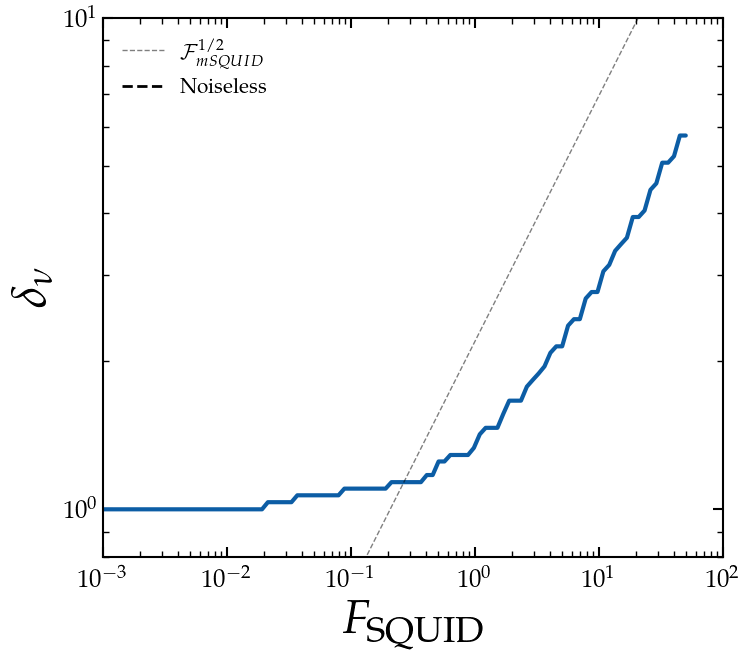

In [16]:
# plt.loglog(sql, dell_sq/dell_sq[0], label='seed: 42')
# plt.loglog(sql, dell_sq2/dell_sq2[0], label='seed: 23')
plt.loglog(sql, me_sq)
plt.loglog(sql, 2.2*sql**(1/2), ls='--', lw=1, alpha=0.5,c='k', label='${\cal F}_{\rm SQUID}^{1/2}$')

de0, _, _ = find_delta(10, 0.16,  T2=1, Nshots=100, seed=42, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=0)

plt.hlines(de0, xmin=1e-3, xmax=50, ls='--', color='k', label='Noiseless', lw=2)
plt.xlim(1e-3,100)
plt.ylim(0.8,10)
plt.xlabel(r'$F_{\rm SQUID}$')
plt.ylabel(r'$\delta_{\nu}$')
plt.legend()
plt.show()

## $T_2$ dependence

In [17]:
t2l = np.geomspace(0.1, 100, 100)
dell_t1 = []
dell_t2 = []
dell_t3 = []
dell_t4 = []
for tt in tqdm.tqdm(t2l):
    de, _,_  = find_delta(10, 0.16, T2=tt, Nshots=100, seed=24, d_init=1e8, d_fin=1e14, ndelta=200)
    dell_t1.append(de)
    de, _,_  = find_delta(10, 0.16, T2=tt, Nshots=100, seed=11, d_init=1e8, d_fin=1e14, ndelta=200)
    dell_t2.append(de)
    de, _,_  = find_delta(10, 0.16, T2=tt, Nshots=100, seed=24, d_init=1e8, d_fin=1e14, ndelta=200)
    dell_t3.append(de)
    de, _,_  = find_delta(10, 0.16, T2=tt, Nshots=100, seed=11, d_init=1e8, d_fin=1e14, ndelta=200)
    dell_t4.append(de)

dell_t1 = np.array(dell_t1)
dell_t2 = np.array(dell_t2)
dell_t3 = np.array(dell_t3)
dell_t4 = np.array(dell_t4)
me_t = np.mean(np.array([dell_t1/dell_t1[0], dell_t2/dell_t2[0], dell_t3/dell_t3[0], dell_t4/dell_t4[0]]), axis=0)


100%|██████████████████████████████████████████████████████████| 100/100 [13:05<00:00,  7.86s/it]


In [22]:
np.savetxt(main_dir+'data/T2_dep.txt', np.column_stack([t2l, me_t]))

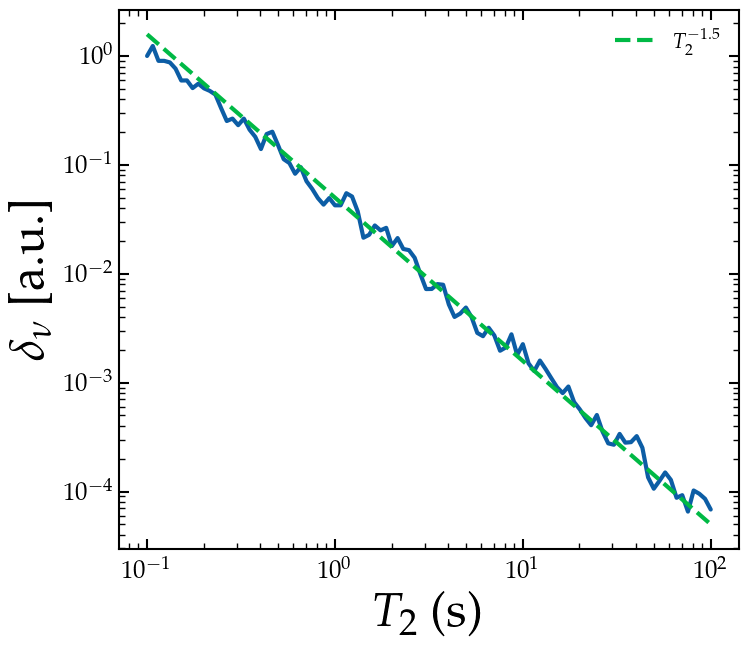

In [19]:
plt.loglog(t2l, me_t)
plt.loglog(t2l, 0.05*t2l**(-1.5), ls='--', label=r'$T_2^{-1.5}$')

plt.xlabel(r'$T_2$ (s)')
plt.ylabel(r'$\delta_{\nu}$ [a.u.]')
plt.legend()
plt.show()

## $N_{\rm shots}$ dependence

In [21]:
de, _, _ = find_delta(10, 0.16, T2=0.01, Nshots=1000, seed=24, d_init=1e12, d_fin=1e17, ndelta=200)
print("%.3e"%de)

3.449e+14


In [32]:
nsl = np.geomspace(5, 1000, 100)
nsl_int = [int(ns) for ns in nsl]

d, d2, d3 = [], [], []

for see in [11, 25, 43, 51]:    
    dell_seed, dell2_seed, dell3_seed = [], [], []

    for ns in tqdm.tqdm(nsl_int):
        de, _, _ = find_delta(10, 0.16, T2=0.01, Nshots=ns, seed=see, d_init=1e12, d_fin=1e19, ndelta=200)
        dell_seed.append(de)

        de, _, _ = find_delta(10, 0.16, T2=0.01, Nshots=ns, seed=see, d_init=1e12, d_fin=1e19, ndelta=200, squid_noise_ratio=1)
        dell2_seed.append(de)

        de, _, _ = find_delta(10, 0.16, T2=0.01, Nshots=ns, seed=see, d_init=1e12, d_fin=1e19, ndelta=200, squid_noise_ratio=10)
        dell3_seed.append(de)

    d.append(dell_seed)
    d2.append(dell2_seed)
    d3.append(dell3_seed)

d = np.array(d)     # shape: (n_seeds, len(nsl))
d2 = np.array(d2)
d3 = np.array(d3)

me_ns1 = np.mean(d, axis=0)
me_ns2 = np.mean(d2, axis=0)
me_ns3 = np.mean(d3, axis=0)

100%|██████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.73s/it]


In [ ]:
np.savetxt(main_dir+'data/Ns1_dep.txt', np.column_stack([nsl, me_ns1]))
np.savetxt(main_dir+'data/Ns2_dep.txt', np.column_stack([nsl, me_ns2]))
np.savetxt(main_dir+'data/Ns3_dep.txt', np.column_stack([nsl, me_ns3]))

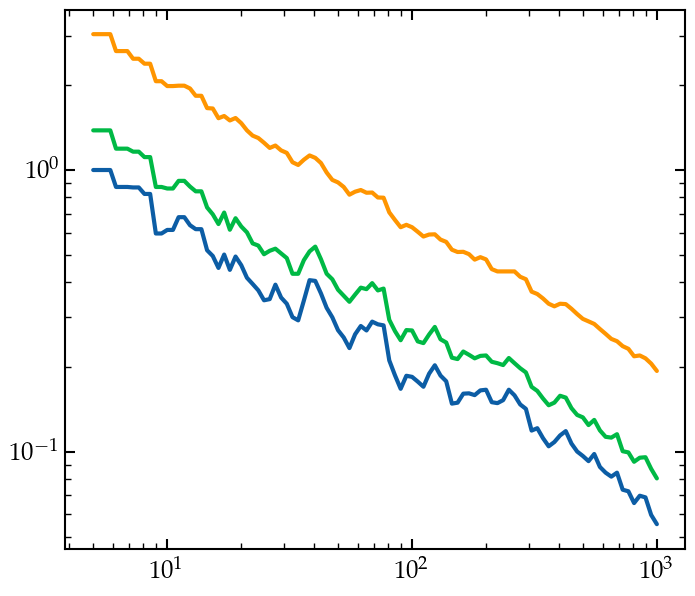

In [34]:
plt.loglog(nsl,me_ns1/me_ns1[0])
plt.loglog(nsl, me_ns2/me_ns1[0])
plt.loglog(nsl, me_ns3/me_ns1[0])
#plt.loglog(nsl, 2*nsl**(-0.5), ls='--')

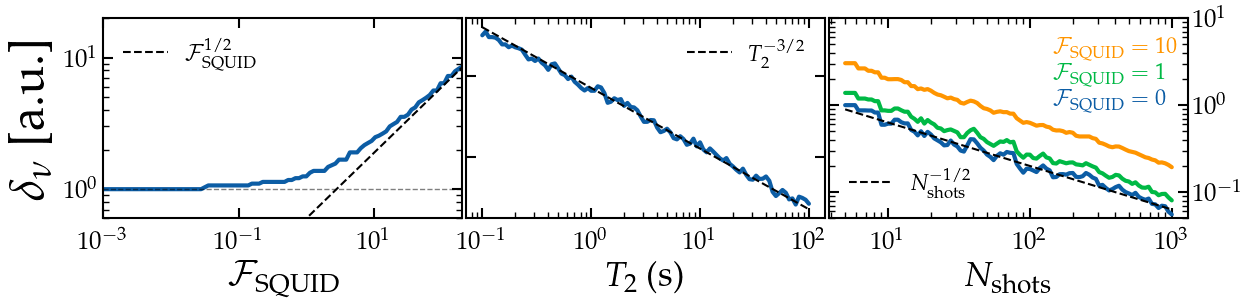

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(14, 2.6))
fig.subplots_adjust(wspace=0.01, hspace=0.34)
fs = 16


#-----------------------------------------------------------------------------------------------------------
ax[0].loglog(sql, me_sq)
ax[0].loglog(sql, 0.6*sql**(1/2), ls='--', lw=1.5, alpha=1,c='k', label=r'${\cal F}_{\rm SQUID}^{1/2}$')
ax[0].loglog(sql, sql/sql, c='k', ls='--', lw=1, alpha=0.5)

ax[0].set_xlim(1e-3, 200)
ax[0].set_ylim(0.6, 20)
ax[0].legend(fontsize=fs, frameon=False)
ax[0].set_xlabel(r'${\cal F}_{\rm SQUID}$', fontsize=25)
ax[0].set_ylabel(r'$\delta_\nu$ [a.u.]')
#ax[0].tick_params(labelleft=False, labelright=True)


# #-----------------------------------------------------------------------------------------------------------
ax[1].loglog(t2l, me_t)
ax[1].loglog(t2l, 0.05*t2l**(-1.5), ls='--', label=r'$T_2^{-3/2}$', c='k',lw=1.5)
ax[1].legend(fontsize=fs, frameon=False)
ax[1].set_xlabel(r'$T_2$ (s)', fontsize=25)
ax[1].tick_params(labelleft=False, labelright=False)
#ax[1].set_ylabel(r'$\delta_\nu$ [a.u.]')

# #-----------------------------------------------------------------------------------------------------------

ax[2].loglog(nsl,me_ns1/me_ns1[0])#, label=r'${\cal F}_{\rm SQUID}=10$')
ax[2].loglog(nsl, me_ns2/me_ns1[0])#, label=r'${\cal F}_{\rm SQUID}=10$')
ax[2].loglog(nsl, me_ns3/me_ns1[0])#, label=r'${\cal F}_{\rm SQUID}=10$')
ax[2].loglog(nsl, 2*nsl**(-0.5), ls='--', c='k', lw=1.5, alpha=1, label=r'$N_{\rm shots}^{-1/2}$')
ax[2].text(145, 4,r'${\cal F}_{\rm SQUID}=10$',c='C2', fontsize=16)
ax[2].text(145, 2,r'${\cal F}_{\rm SQUID}=1$',c='C1', fontsize=16)
ax[2].text(145, 1,r'${\cal F}_{\rm SQUID}=0$',c='C0', fontsize=16)
ax[2].set_xlabel(r'$N_{\rm shots}$', fontsize=25)
ax[2].set_ylim(0.05, 10)
ax[2].legend(fontsize=fs, loc=3)
ax[2].tick_params(labelleft=False, labelright=True)

# plt.tight_layout()
plt.show()
fig.savefig(main_dir+'plots/delta_scaling.pdf', bbox_inches='tight')

## Mass plot

In [83]:
mnl = np.linspace(0.001, 3, 100)
dell_m = []
dell_m_0 = []

for m in tqdm.tqdm(mnl):
    de, c2, _ = find_delta(1, m, T2=10, Nshots=10, seed=42, d_init=1e9, d_fin=1e17, ndelta=200, squid_noise_ratio=10.0)
    dell_m.append(de)
    de, c2, _ = find_delta(10, m, T2=10, Nshots=10, seed=42, d_init=1e8, d_fin=2e14, ndelta=200, squid_noise_ratio=0.0)
    dell_m_0.append(de)

dell_m = np.array(dell_m)
dell_m_0 = np.array(dell_m_0)

100%|██████████████████████████████████████████████████████████| 100/100 [05:03<00:00,  3.04s/it]


In [405]:
# de, c2, _ = find_delta(10, 0.001, T2=10, Nshots=10, seed=42, d_init=1e9, d_fin=1e17, ndelta=200, squid_noise_ratio=0.0)
# print("%.3e"%de)

6.080e+13


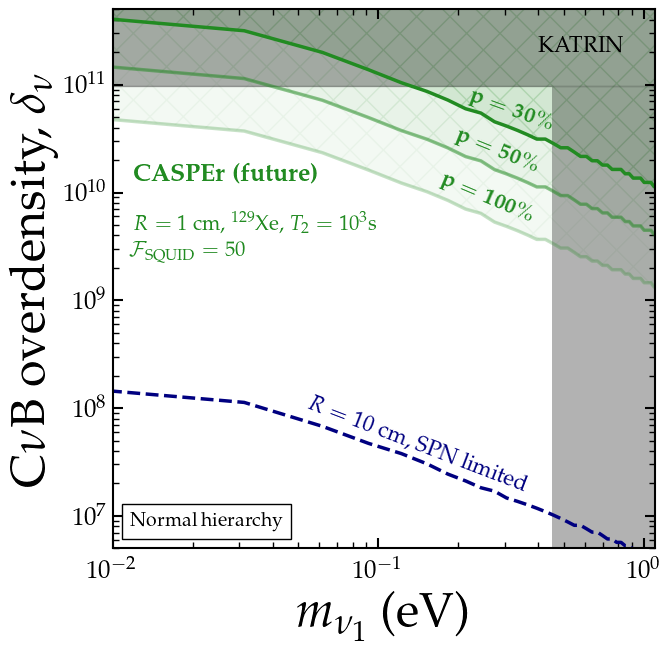

In [199]:
fig, ax = plt.subplots(figsize=(7,7))


c1 = 'forestgreen'
c2 = 'navy'

al = 0.05

f1 = 1/(100**(3/2))*(1/0.3)**2/10*(50/10)**(1/2)
f2 = 1/(100**(3/2))*(1/0.5)**2/10*(50/10)**(1/2)
f3 = 1/(100**(3/2))/10*(85/10)**(1/2)
f4 = 1/(100**(3/2))/10

plt.loglog(mnl, dell_m*f1, c=c1, lw=2.5)
plt.fill_between(mnl, dell_m*f1, 1e16*np.ones(len(mnl)), alpha=0.2, color=c1, hatch='X')

plt.loglog(mnl, dell_m*f2, c=c1, lw=2.5, alpha=0.5)
plt.fill_between(mnl, dell_m*f2, dell_m*f1, alpha=0.1, color=c1, hatch='X')

plt.loglog(mnl, dell_m*f3, c=c1, lw=2.5, alpha=0.25)
plt.fill_between(mnl, dell_m*f3, dell_m*f2, alpha=0.05, color=c1, hatch='X')


plt.text(0.012,1.3e10,r'{\bf CASPEr (future)}', fontsize=18, c=c1)
plt.text(0.012,4.5e9,r'$R=1$ cm, $^{129}$Xe, $T_2=10^3$s', fontsize=15, c=c1)
#plt.text(0.15,4e12,r'$T_2=10^3$ s, ${\cal F}_{\rm SQUID}=10$', fontsize=15, c='k')
plt.text(0.0115,2.6e9,r'${\cal F}_{\rm SQUID}=50$', fontsize=15, c=c1)

plt.text(0.215,3.9e10,r'${\bf p=30\%}$', fontsize=16,c=c1, alpha=1, rotation=-20)
plt.text(0.19,1.6e10,r'${\bf p=50\%}$', fontsize=16,c=c1, alpha=1, rotation=-22)
plt.text(0.168,5.5e9,r'${\bf p=100\%}$', fontsize=16,c=c1, alpha=1, rotation=-23)

plt.loglog(mnl, dell_m_0*f4, c=c2, lw=2.5, ls='--')
plt.text(0.053,1.7e7,r'$R=10$ cm, SPN limited', fontsize=16,c=c2, rotation=-21)
# plt.text(0.075,7.3e6,r'(SPN limited)', fontsize=16,c=c2, rotation=-15)

mm = np.geomspace(1e-3, 2,100)
mm2 = np.geomspace(1e-3, 0.45,100)
#plt.text(1.2e-2, 5e10, r'KATRIN, $\delta_\nu$', fontsize=16, alpha=1, c='k')
plt.fill_between(mm, 9.7e10,  1e15, alpha=0.3, color='k')
#plt.loglog(mm, mm/mm*9.7e10, ls='--', lw=1.5, alpha=1, c='k')

# plt.text(1.2e-2, 1e10, 'KATRIN (3 yr projection)', fontsize=16, alpha=0.4, c='k')
#plt.loglog(mm, mm/mm*2e10, ls='--', lw=1.5, alpha=0.4, c='k')

yy = np.geomspace(1e6, 9.45e10,100)
plt.fill_betweenx(yy, 0.45, 2, color='k', alpha=0.3, lw=0.001)
plt.text(4e-1, 2e11, 'KATRIN', fontsize=16, alpha=1, c='k')
# plt.text(6.2e-1, 2e9, r'$m_\nu$', fontsize=16, alpha=1, c='k')


# plt.text(0.8e-1, 3e11, r'Arvanitaki et al., ~~$R=10$ cm, $T_2=10^3$ s ~($^1$H)', fontsize=16, alpha=0.5, c='k')
# plt.loglog(mm, mm/mm*2e11, ls='--', lw=1.5, alpha=0.5, c='k')

# plt.hlines(4.7e7,mm[0], mm[-1])
# plt.axvline(0.15)

text_box = AnchoredText(
    fr"Normal hierarchy", 
    loc='lower left',            
    frameon=True,                
    prop=dict(size=14)
)
ax.add_artist(text_box)

plt.xlabel(r'$m_{\nu_1}$ (eV)')
plt.ylabel(r'C$\nu$B overdensity, $\delta_{\nu}$')
plt.xlim(1e-2, 1.1)
plt.ylim(5e6, 5e11)
plt.show()
fig.savefig(main_dir+'plots/deltanu_m1.pdf', bbox_inches='tight')

In [ ]:
# Digitise from 2507.14287
pair_abs = np.array([[0.0005177804903556527, 1657834326.7389877],
[0.07786413634147336, 1688824073.6577861],
[0.10204972715309346, 1714415017.035888],
[0.15311700072452655, 1741263547.1626225],
[0.27763041550136264, 1845905783.0879643],
[0.4318588848004305, 1955728771.2530704],
[0.6363877327067246, 2130669274.627967],
[0.97222098328159, 2387681798.680744],
[1.3944324890661355, 2601000694.336299],
[1.98204807003649, 2833283426.0644603]])
plt.text(2e-5, 6e8, r'Pair absorption', rotation=0,c='crimson')
plt.loglog(pair_abs[:,0]/1e3, pair_abs[:,1],c='crimson')

In [251]:
(Ncode/4+2*Ncode*(Ncode+1)*0.01)/Ncode

2000000.27

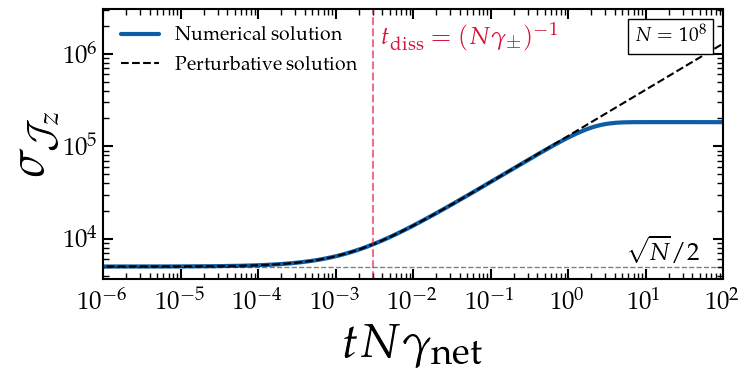

In [351]:
fig, ax = plt.subplots(figsize=(8,3.5))

Ncode = 1e8

gpr = 0.997
t, jz, s0 = solve(Ncode, gp_ratio=gpr, gd_ratio=0, ti=1e-4, tf=1e5, ntimes=200, p_init=1)

plt.loglog(t*(1-gpr), s0, label='Numerical solution')#/Ncode**(1/2)*2)
plt.loglog(t*(1-gpr), np.sqrt((Ncode/4*t/t)), c='k', ls='--', alpha=0.5, lw=1, )
plt.loglog(t*(1-gpr), np.sqrt((Ncode/4*t/t)+1/2*(Ncode+Ncode**(1/2))*t), c='k', ls='--', lw=1.5, label='Perturbative solution')

plt.axvline(1-gpr, c='crimson', ls='--', lw=1.5, alpha=0.6)
plt.text(4e-3, 1.3e6, r'$t_{\rm diss}=(N\gamma_{\pm})^{-1}$',c='crimson', fontsize=18)
plt.text(6, 6e3, '$\sqrt{N}/2$', fontsize=18)

text_box = AnchoredText(
    fr"$N=10^8$", 
    loc='upper right',            
    frameon=True,                
    prop=dict(size=14)
)
ax.add_artist(text_box)

plt.xlim(1e-6, 1e2)
# plt.ylim(0.5, 500)
plt.legend(fontsize=14)
plt.xlabel(r'$tN\gamma_{\rm net}$')
plt.ylabel(r'$\sigma_{{\cal J}_z}$')
plt.show()
fig.savefig(main_dir+'plots/sigma_z.pdf', bbox_inches='tight')

In [207]:
# Ncode = 1e3
# t, jz, sz = solve(Ncode,gp_ratio=0.5,gd_ratio=0, p_init=1, ti=1e-20)
# print('Here')

# n = 1000
# path  = main_dir+f'../OpenNu/output/N%d'%n
# data = np.loadtxt(path+f'/Product_RK4_h0.1_g0.50.txt')

# # Jz
# # plt.loglog(t, np.abs(jz)/Ncode*2, label='2nd')
# # plt.loglog(data[:,0], np.abs(data[:,3])/Ncode*2, label='full')

# # Sz
# plt.loglog(t, sz/np.sqrt(Ncode)*2, label='2nd')
# plt.loglog(data[:,0], np.sqrt(data[:,6]-data[:,3]**2)/np.sqrt(Ncode)*2, label='full')

# # plt.xlim(5e-3, 1e2)
# # plt.ylim(1e-6, 0.1)
# plt.legend()
# plt.show()

In [208]:
# Ncode = 1e8
# t, jz, sz = solve(Ncode,gp_ratio=0.5,gd_ratio=0, p_init=1, ti=1e-20)

# plt.loglog(t, sz/Ncode**(1/2)*2, label='2nd')

In [184]:
R = 10
mnu = 0.15
p_init=1
sampf=14.3e3
B=0.1
T2=1
ns=1.35e22
Nshots=100
seed=42
d_init=1e5
d_fin=1e20
ndelta=100
chi2_crit=2.7
squid_noise_ratio=0.0
ncode=1e10
A=129
Z=54
gy=11.78e6

eVHz   = 1 / 6.58e-16                   # eV/Hz conversion
w0     = 2 * np.pi * gy * B / eVHz      # eV
knu    = 1 / 0.037                      # cm^-1
N      = ns * 4 * np.pi / 3 * R**3      # number of spins
fsup   = (knu * R)**3                   # coherent suppression factor

# --- Time grid ---
tf       = T2
ti       = 1 / sampf
n_times  = int((tf - ti) * sampf)
t_exp    = np.geomspace(ti, tf, n_times)

# --- Gamma ratios ---
gratio, gm = ga.compute_ratio(mnu, w0, A=A, Z=Z)

In [185]:
# Simulate raw samples
np.random.seed(seed)
jz_true_mean = 0.0
jz_true_std = np.sqrt(N / 4)

Jz_samples = np.random.normal(jz_true_mean, jz_true_std, size=(n_times, Nshots))
Jz_mean_exp = np.mean(Jz_samples, axis=1) / (N / 2)

# Total std dev normalized (quantum + SQUID noise)
#sigma_jz = np.sqrt(((N / 4) )/ Nshots + squid_noise_ratio * (N / 4)) / (N / 2) * np.ones(n_times)

In [145]:
# plt.scatter(t_exp, Jz_mean_exp)
# _, jz_pred = get_model_jz(1e16)
# plt.loglog(t_exp, jz_pred)

# plt.xscale('log')

In [130]:
# delta = 1e25

# tmin_code = min(t_exp) * N * gm * delta / fsup
# tmax_code = max(t_exp) * N * gm * delta / fsup

# print(tmin_code)
# print(tmax_code)

In [186]:
# --- Memoized model prediction for normalized ⟨J_z⟩ ---
@lru_cache(maxsize=64)
def get_model_jz(delta):
    Ncode = int(ncode)
    
    tmin_code = min(t_exp) * N * gm / (1-gratio) * delta / fsup
    tmax_code = max(t_exp) * N * gm / (1-gratio) * delta / fsup
    #print(tmin_code)
    #print(tmax_code)
    t, jz, sz = solve(
        Ncode,
        gp_ratio=gratio,
        gd_ratio=Ncode,
        p_init=p_init,
        ti=tmin_code,
        tf=tmax_code,
        ntimes=n_times
    )

    jz_norm = jz / (Ncode / 2)
    sz_norm = sz/ ( Ncode**(1/2) / 2)
    return t, np.abs(jz_norm), sz_norm

delta_list = np.geomspace(d_init, d_fin, ndelta)
chi2_min = np.inf
delta_best = None
delta_crit = None

chi2l = []

for delta in delta_list:
    t_pred, jz_pred, sz_pred = get_model_jz(delta)
    sigma_jz = np.sqrt(sz_pred**2/Nshots + squid_noise_ratio)/np.sqrt(N)*2
    #sigma_jz = np.sqrt((N/4) / Nshots + squid_noise_ratio * (N / 4)) / (N / 2)
    chi2 = np.sum(((Jz_mean_exp - jz_pred) / sigma_jz) ** 2)
    chi2l.append(chi2)

    if chi2 < chi2_min:
        chi2_min = chi2
        delta_best = delta

    if delta_crit is None and chi2 - chi2_min > chi2_crit:
        delta_crit = delta
        break

if delta_crit is None:
   print("No delta found within scan range for J_z")

print("%.3e"%delta_crit)
# print(chi2/chi2_min)
# print(chi2l)

1.874e+12


In [189]:
print("%.3e"%(1.88e12/np.sqrt(10)*1e-3))

5.945e+08


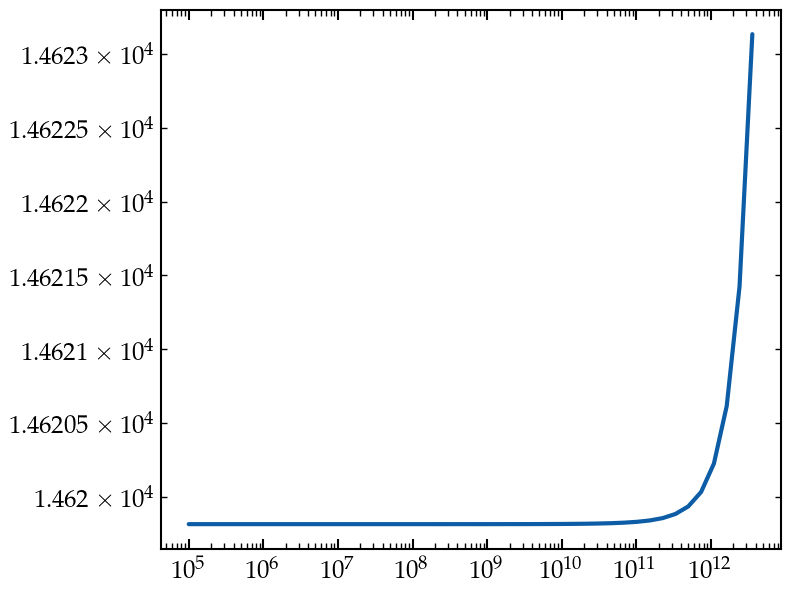

In [76]:
plt.loglog(delta_list[:45], chi2l)

3.8716755095917754e-17


ValueError: x and y must have same first dimension, but have shapes (14239,) and (0,)

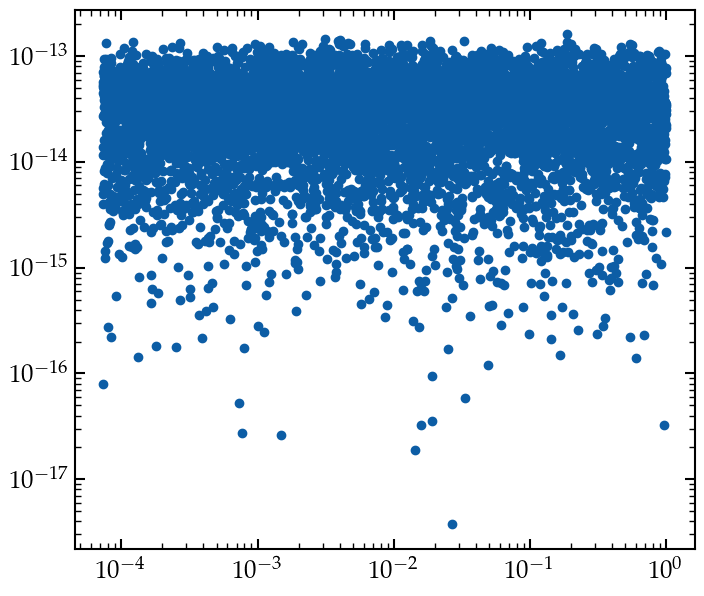

In [85]:
delta = 1e12
s = 60 

_, jz_pred = get_model_jz(delta)
#sigma_jz = np.sqrt(sz_pred**2/Nshots)

#chi2 = np.sum(((Jz_mean_exp[s:] - jz_pred[s:]) / sigma_jz[s:]) ** 2)

plt.scatter(t_exp[s:], Jz_mean_exp[s:])
plt.loglog(t_exp[s:], jz_pred[s:])

In [212]:
delta

np.float64(1.555676143930466e+17)

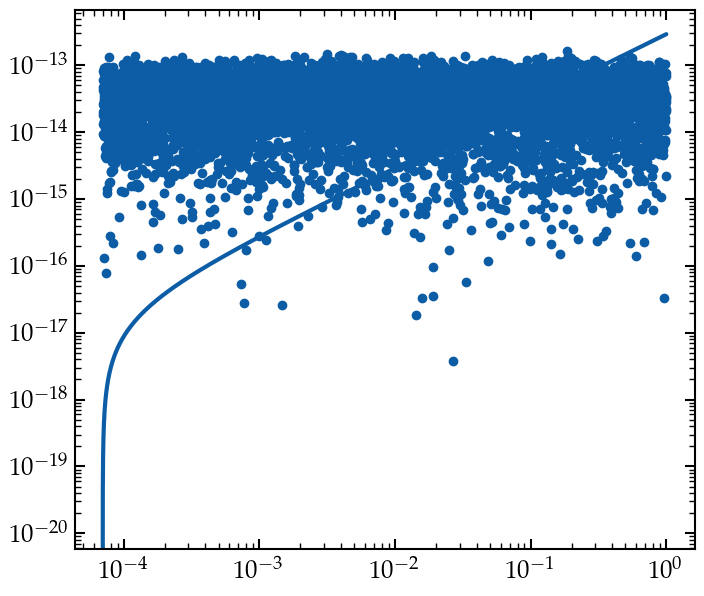

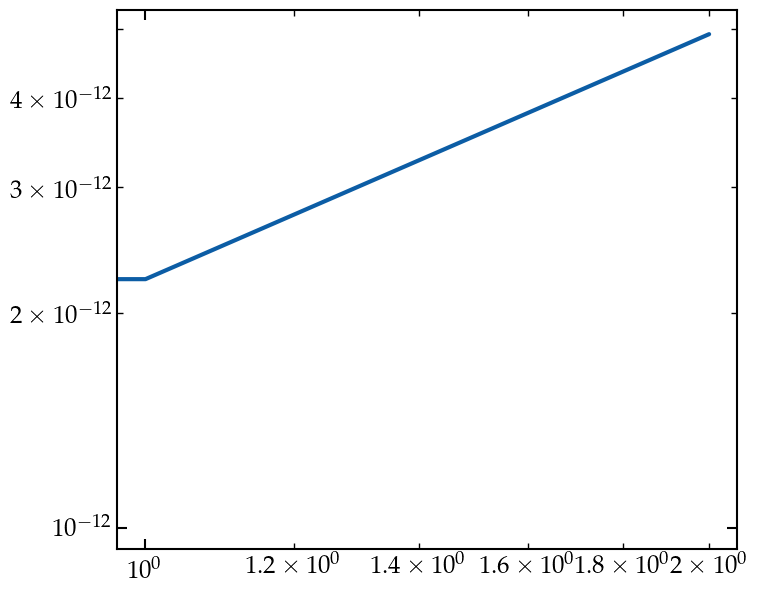

In [201]:
plt.loglog(chi2l)

In [ ]:
10**

In [173]:
chi2l

[np.float64(2.533276465663298e-17),
 np.float64(2.5332764656634235e-17),
 np.float64(2.5332764657088064e-17),
 np.float64(2.5332764858592065e-17),
 np.float64(2.533779766657954e-17),
 np.float64(6.678055447468238e-16)]

In [123]:
chi2l[50]

np.float64(2.6142440267100333e-22)

In [ ]:
print("%.3e"%delta_crit)

In [65]:
delta_list

array([1.00000000e+05, 1.35304777e+05, 1.83073828e+05, 2.47707636e+05,
       3.35160265e+05, 4.53487851e+05, 6.13590727e+05, 8.30217568e+05,
       1.12332403e+06, 1.51991108e+06, 2.05651231e+06, 2.78255940e+06,
       3.76493581e+06, 5.09413801e+06, 6.89261210e+06, 9.32603347e+06,
       1.26185688e+07, 1.70735265e+07, 2.31012970e+07, 3.12571585e+07,
       4.22924287e+07, 5.72236766e+07, 7.74263683e+07, 1.04761575e+08,
       1.41747416e+08, 1.91791026e+08, 2.59502421e+08, 3.51119173e+08,
       4.75081016e+08, 6.42807312e+08, 8.69749003e+08, 1.17681195e+09,
       1.59228279e+09, 2.15443469e+09, 2.91505306e+09, 3.94420606e+09,
       5.33669923e+09, 7.22080902e+09, 9.77009957e+09, 1.32194115e+10,
       1.78864953e+10, 2.42012826e+10, 3.27454916e+10, 4.43062146e+10,
       5.99484250e+10, 8.11130831e+10, 1.09749877e+11, 1.48496826e+11,
       2.00923300e+11, 2.71858824e+11, 3.67837977e+11, 4.97702356e+11,
       6.73415066e+11, 9.11162756e+11, 1.23284674e+12, 1.66810054e+12,
      

In [3]:
%%time

R = 10    # cm
m = 0.16  # eV


de, c2, c2l = on.get_delta_jz2(10, 0.16, p_init=1, T2=10, Nshots=100, seed=42, d_init=1e8, d_fin=1e15, ndelta=100,
                 chi2_crit=2.7, squid_noise_ratio=0)
print("\ndelta: %.3e\n"%de)

/home/g/work/OQS/pyOpenNu/notebooks/../opennu.py:284: RuntimeWarning: divide by zero encountered in divide
  chi2 = np.sum(((Jz_mean_exp - jz_pred) / sz_pred) ** 2)
/home/g/work/OQS/pyOpenNu/notebooks/../opennu.py:289: RuntimeWarning: invalid value encountered in scalar subtract
  if chi2 - chi2_min > chi2_crit:



delta: 1.000e+15

CPU times: user 11.1 s, sys: 41 ms, total: 11.1 s
Wall time: 11.1 s


/home/g/work/OQS/pyOpenNu/notebooks/../opennu.py:295: RuntimeWarning: invalid value encountered in scalar subtract
  return delta_crit, chi2 - chi2_min, chi2l


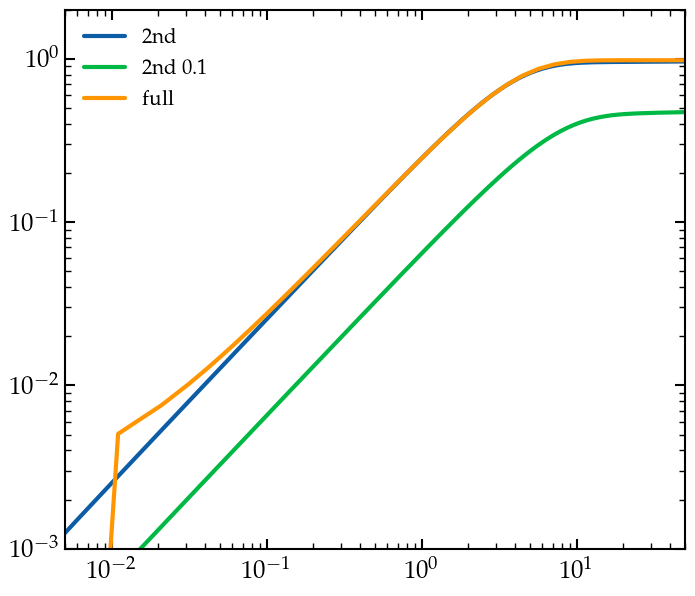

In [108]:
Ncode = 1e2
t, jz, sz = solve(Ncode,gp_ratio=0.5,gd_ratio=0)
t, j2, sz = solve(Ncode,gp_ratio=0.5,gd_ratio=0, p_init=0.5)


n = 100
path  = main_dir+f'../OpenNu/output/N%d'%n
data = np.loadtxt(path+f'/Product_RK4_h0.1_g0.50.txt')

plt.loglog(t, np.abs(jz)/Ncode*2, label='2nd')
plt.loglog(t, np.abs(j2)/Ncode*2, label='2nd 0.1')
plt.loglog(data[:,0], np.abs(data[:,3])/Ncode*2, label='full')

plt.xlim(5e-3, 5e1)
plt.ylim(1e-3, 2)
plt.legend()
plt.show()

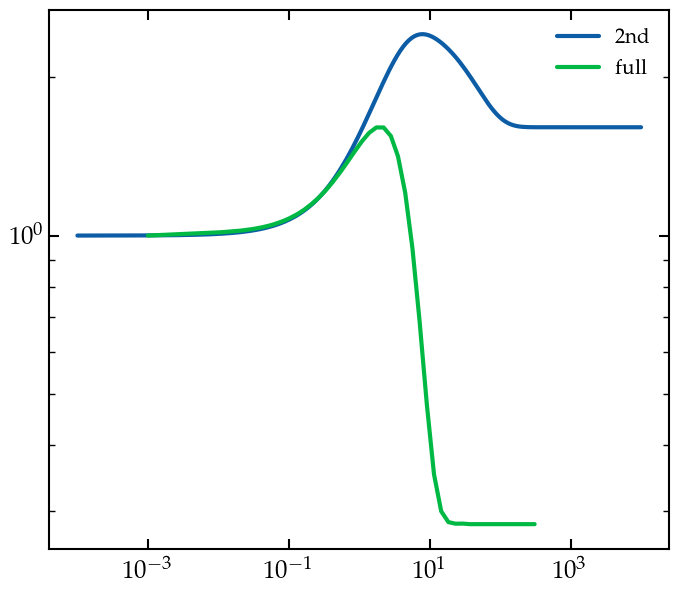

In [76]:
plt.loglog(t, sz/np.sqrt(Ncode)*2, label='2nd')
plt.loglog(data[:,0], np.sqrt((data[:,6]-np.abs(data[:,3])**2))/np.sqrt(Ncode)*2, label='full')
plt.legend()

In [37]:
jz[100]

np.float64(-127.92629123205217)

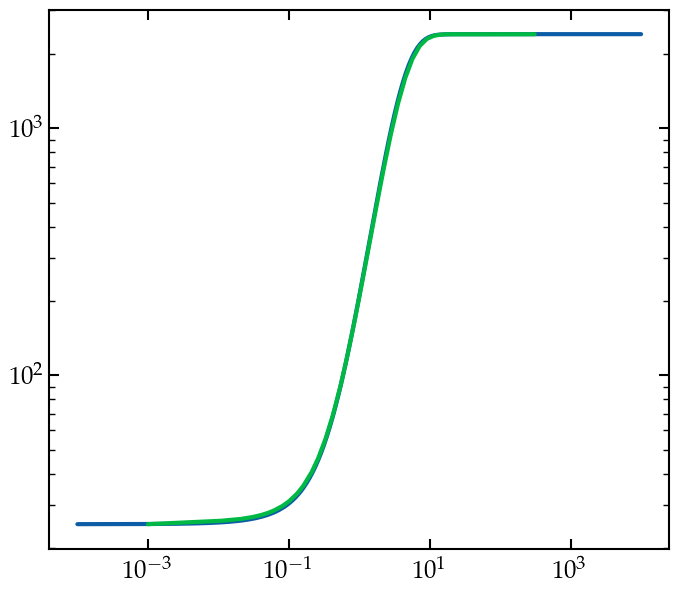

In [62]:
plt.loglog(t, jz2, label='2nd')
plt.loglog(data[:,0], data[:,6], label='full')

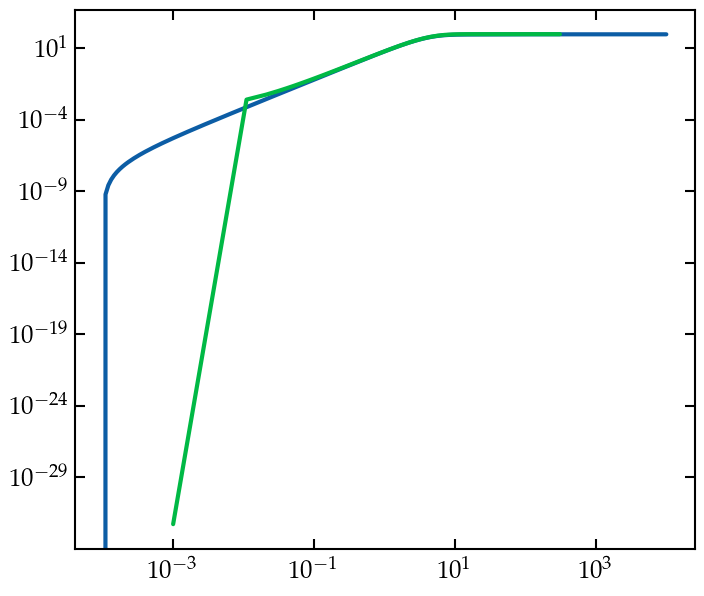

In [63]:
plt.loglog(t, jz**2/Ncode*4, label='2nd')
plt.loglog(data[:,0], data[:,3]**2/Ncode*4, label='full')

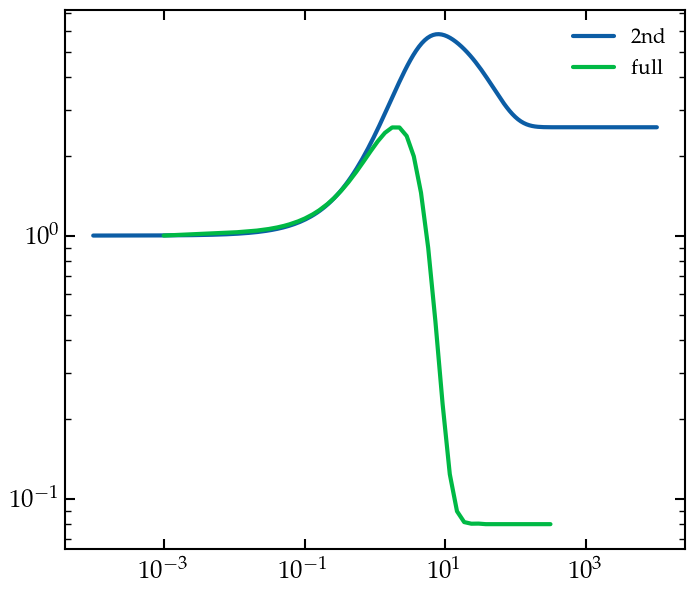

In [64]:

plt.legend()

In [7]:
%%time

R = 10    # cm
m = 0.16  # eV


de, c2, c2l = on.get_delta_jz(10, 0.16, p_init=1.0, T2=10, Nshots=10, seed=42, d_init=1e1, d_fin=1e25, ndelta=100,
                 chi2_crit=2.7, squid_noise_ratio=0.0, ncode=1e10)
print("\ndelta: %.3e\n"%de)


delta: 1.072e+24

CPU times: user 4.65 s, sys: 4.01 ms, total: 4.65 s
Wall time: 4.65 s


In [8]:
print("\ndelta: %.3e\n"%(1.5e10/(100**(3/2)))


delta: 1.500e+07



In [3]:
Ncode = 1e8

t, jz, jz2, _, _ = on.solve2nd(Ncode,state='P',gp_ratio=0.997,gd_ratio=0, p_init=1)
t, jz, jz22, _, _ = on.solve2nd(1e5,state='P',gp_ratio=0.997,gd_ratio=0, p_init=1)
t, _, _, jx2, _  = on.solve2nd(Ncode,state='G',gp_ratio=0.997,gd_ratio=Ncode, p_init=1)

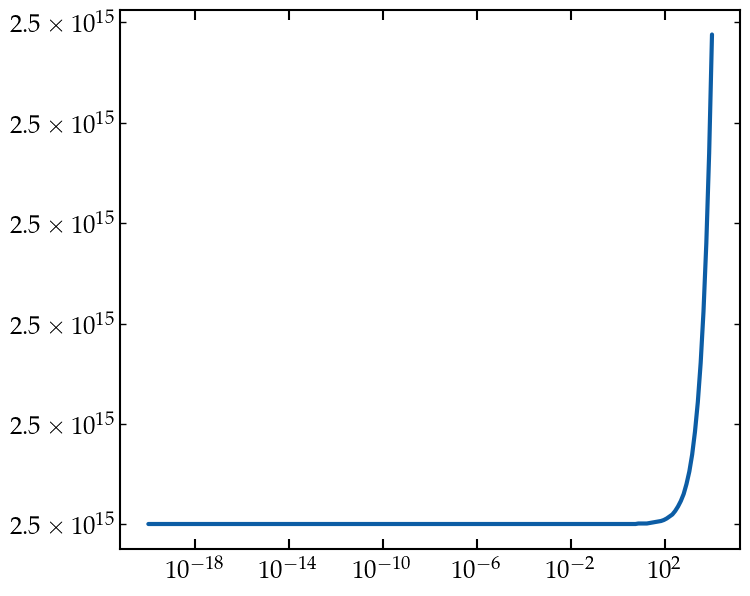

In [9]:
t2, jzP, jz2P, jx2P, _ = on.solve2nd(1e8, state='P', gp_ratio=0.95, gd_ratio=0, ti=1e-20)
plt.loglog(t2, jz2P)

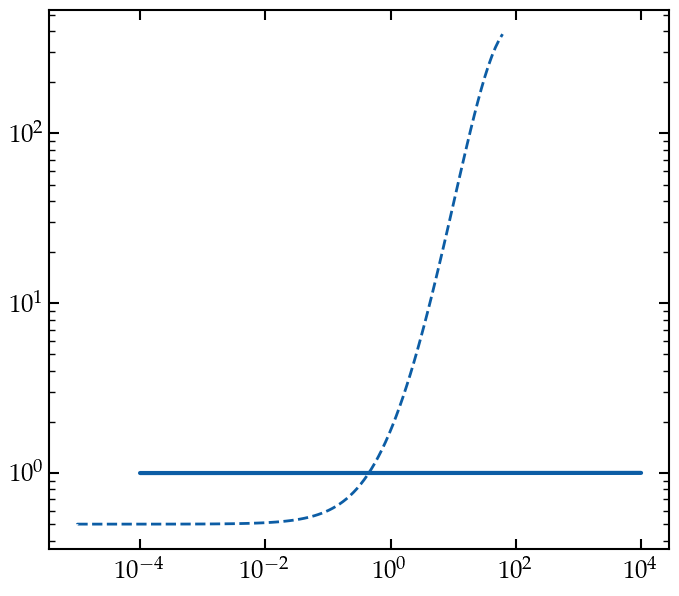

In [36]:
n = 1000
path  = main_dir+f'../OpenNu/output/N%d'%n
data = np.loadtxt(path+f'/Product_Euler_h0.1_g0.95.txt')
t = data[:,0]
#snr = -(data[:,3]-data[0,3])/(data[:,6]-data[:,3]**2)**(1/2)

newt = t*n**(1/2)*(0.05)
#newsnr = snr*n**(-1/4)
plt.loglog(t, data[:,6]/1e3*2, ls='--', c='C0', lw=2)

for N in [1e3]:

    t, jzP, jz2P, jx2P, _ = on.solve2nd(N, state='P', gp_ratio=0.997, gd_ratio=0)
    # tn = t*N**(1/2)*0.05
    # snr = -(jzP-jzP[0])/(jz2P-jzP**2)**(1/2)*N**(-1/2)
    plt.loglog(t, jz2P/1e3**2*4, label=r'$N=10^{%d}$'%(np.log10(N)))
    
    # if N> 10:
    # idx = np.where(snr>1)[0][0]
    # print("N=%.1e,  SNR=1: t=%.3f"%(N, tn[idx]))




In [3]:
# Ncode = 1e8

# ti = 1e-10
# tf = 1e2

# t, j0, _, _, _ = on.solve2nd(Ncode, state='P', p_init=1.0,  tf=tf, ti=ti, gd_ratio=0)
# t, j1, _, _, _ = on.solve2nd(Ncode, state='P', p_init=0.1, tf=tf, ti=ti, gd_ratio=0)

# plt.loglog(t, np.abs(j0)/Ncode*2)
# plt.loglog(t, np.abs(j1)/Ncode*2)

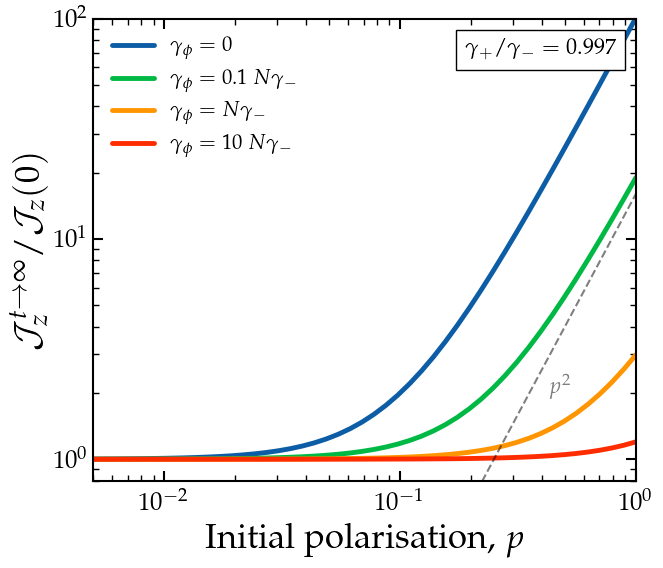

In [95]:
Ncode = 1e8

ti = 1e-5
tf = 1e5

fig, ax = plt.subplots(figsize=(7,6))

pols = np.geomspace(1e-5, 1, 100)
jj0 = []
jj1 = []
jj2 = []
jj3 = []
for p in pols:

    t, j0, _, _, _ = on.solve2nd(Ncode, state='P', p_init=p, gp_ratio=0.997, tf=tf, ti=ti, gd_ratio=0)
    t, j1, _, _, _ = on.solve2nd(Ncode, state='P', p_init=p, gp_ratio=0.997, tf=tf, ti=ti, gd_ratio=0.1*Ncode)
    t, j2, _, _, _ = on.solve2nd(Ncode, state='P', p_init=p, gp_ratio=0.997, tf=tf, ti=ti, gd_ratio=Ncode)
    t, j3, _, _, _ = on.solve2nd(Ncode, state='P', p_init=p, gp_ratio=0.997, tf=tf, ti=ti, gd_ratio=10*Ncode)
    jj0.append(np.abs(j0[-1]))
    jj1.append(np.abs(j1[-1]))
    jj2.append(np.abs(j2[-1]))
    jj3.append(np.abs(j3[-1]))

jj0 = np.array(jj0)
jj1 = np.array(jj1)
jj2 = np.array(jj2)
jj3 = np.array(jj3)

plt.loglog(pols, jj0/jj0[0], lw=3.5, label=r'$\gamma_{\phi}=0$')
plt.loglog(pols, jj1/jj1[0], lw=3.5, label=r'$\gamma_{\phi}=0.1~N\gamma_-$')
plt.loglog(pols, jj2/jj2[0], lw=3.5, label=r'$\gamma_{\phi}=N\gamma_-$')
plt.loglog(pols, jj3/jj3[0], lw=3.5, label=r'$\gamma_{\phi}=10~N\gamma_-$')

plt.loglog(pols*25, 1e4*pols**2, c='k', ls='--', lw=1.5, alpha=0.5)
plt.text(0.43, 2, r'$p^2$', fontsize=16, alpha=0.5, c='k')


gamma = 0.997
text_box = AnchoredText(
    fr"$\gamma_+/\gamma_- = {gamma:.3f}$", 
    loc='upper right',            
    frameon=True,                
    prop=dict(size=16)
)
ax.add_artist(text_box)


plt.xlabel(r'Initial polarisation, $p$', fontsize=25)
plt.ylabel(r'${\cal J}_z^{{t \to\infty}}/{\cal J}_z(0)$', fontsize=25)
plt.legend()
plt.xlim(5e-3, 1)
plt.ylim(0.8, 1e2)
plt.show()
#fig.savefig(main_dir+'plots/sigmax_t.pdf', bbox_inches='tight')

In [228]:
Ncode = 1e8

ti = 1e-5
tf = 1e5

pols = np.geomspace(1e-5, 1, 100)
jj0 = []
jj1 = []
jj2 = []
jj3 = []
for p in pols:

    t, j0, _, = solve(Ncode, p_init=p, gp_ratio=0.997, tf=tf, ti=ti, gd_ratio=0.01*Ncode)
    t, j1, _, = solve(Ncode, p_init=p, gp_ratio=0.997, tf=tf, ti=ti, gd_ratio=0.1*Ncode)
    t, j2, _, = solve(Ncode, p_init=p, gp_ratio=0.997, tf=tf, ti=ti, gd_ratio=Ncode)
    t, j3, _, = solve(Ncode, p_init=p, gp_ratio=0.997, tf=tf, ti=ti, gd_ratio=10*Ncode)
    jj0.append(np.abs(j0[-1]))
    jj1.append(np.abs(j1[-1]))
    jj2.append(np.abs(j2[-1]))
    jj3.append(np.abs(j3[-1]))

jj0 = np.array(jj0)
jj1 = np.array(jj1)
jj2 = np.array(jj2)
jj3 = np.array(jj3)

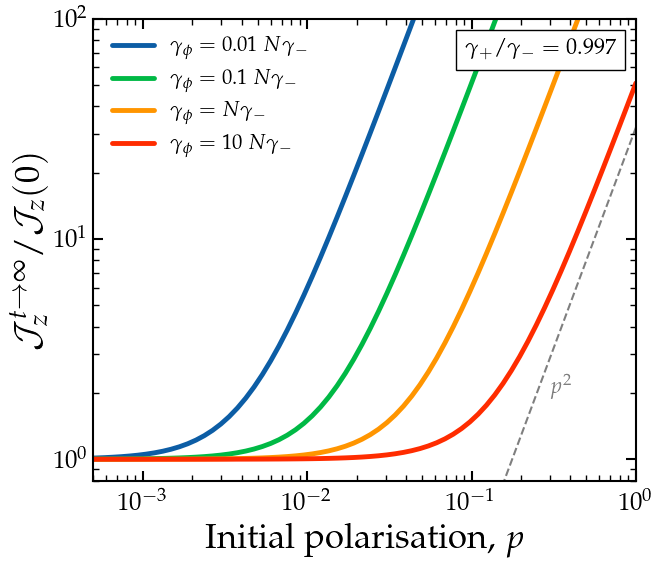

In [231]:
fig, ax = plt.subplots(figsize=(7,6))

plt.loglog(pols, jj0/jj0[0], lw=3.5, label=r'$\gamma_{\phi}=0.01~N\gamma_-$')
plt.loglog(pols, jj1/jj1[0], lw=3.5, label=r'$\gamma_{\phi}=0.1~N\gamma_-$')
plt.loglog(pols, jj2/jj2[0], lw=3.5, label=r'$\gamma_{\phi}=N\gamma_-$')
plt.loglog(pols, jj3/jj3[0], lw=3.5, label=r'$\gamma_{\phi}=10~N\gamma_-$')

plt.loglog(pols*25, 2e4*pols**2, c='k', ls='--', lw=1.5, alpha=0.5)
plt.text(0.3, 2, r'$p^2$', fontsize=16, alpha=0.5, c='k')


gamma = 0.997
text_box = AnchoredText(
    fr"$\gamma_+/\gamma_- = {gamma:.3f}$", 
    loc='upper right',            
    frameon=True,                
    prop=dict(size=16)
)
ax.add_artist(text_box)


plt.xlabel(r'Initial polarisation, $p$', fontsize=25)
plt.ylabel(r'${\cal J}_z^{{t \to\infty}}/{\cal J}_z(0)$', fontsize=25)
plt.legend()
plt.xlim(5e-4, 1)
plt.ylim(0.8, 1e2)
plt.show()
fig.savefig(main_dir+'plots/jz_p.pdf', bbox_inches='tight')

In [4]:
print("\ndelta: %.3e\n"%(de/10))


delta: 5.298e+07



In [9]:
%%time
de, c2, c2l = on.get_delta_jz(10, 0.16, p_init=1, T2=1000, Nshots=10, seed=42, d_init=1e8, d_fin=2e8, ndelta=30,
                 chi2_crit=2.7, squid_noise_ratio=0.0)
print("\ndelta: %.3e\n"%de)


delta: 1.33e+08

CPU times: user 1min 50s, sys: 14.7 s, total: 2min 5s
Wall time: 1min 15s


In [10]:
%%time
de, c2, c2l = on.get_delta_jz(10, 0.16, p_init=1, T2=1000, Nshots=10, seed=42, d_init=1e8, d_fin=2e8, ndelta=30,
                 chi2_crit=3.84, squid_noise_ratio=0.0)
print("\ndelta: %.3e\n"%de)


delta: 1.43e+08

CPU times: user 2min 15s, sys: 18.6 s, total: 2min 34s
Wall time: 1min 32s


In [4]:
# %%time
# de, c2, c2l = on.get_delta_jz(10, 0.16, p_init=1, T2=1000, Nshots=10, seed=42, d_init=1e9, d_fin=1e15, ndelta=100,
#                  chi2_crit=2.7, squid_noise_ratio=0.0)
# print("\ndelta: %.2e\n"%de)

In [3]:
%%time
de, c2, c2l = on.get_delta_jz(10, 0.16, p_init=1, T2=1000, Nshots=10, seed=42, d_init=1e7, d_fin=2e8, ndelta=20,
                 chi2_crit=2.7, squid_noise_ratio=0.0)
print("\ndelta: %.2e\n"%de)


delta: 1.25e+08

CPU times: user 2min 23s, sys: 20.9 s, total: 2min 44s
Wall time: 1min 39s


In [5]:
print("%.1e"%(1.25e7*10**(1/2)*10000*100**(1.3)))

1.6e+14


### $M_{\nu}=\sum m_{\nu}$ dependence

In [15]:
mnl = np.linspace(0.06, 1, 30)
dell_m = []
dell_m2 = []
for m in tqdm.tqdm(mnl):
    de, c2, _ = on.get_delta_jz(10, m, T2=1, Nshots=10, seed=42, d_init=1e14, d_fin=2e16, ndelta=200)
    de2, c2, _ = on.get_delta_jz(10, m, T2=1, Nshots=10, seed=23, d_init=1e14, d_fin=2e16, ndelta=200)
    dell_m.append(de)
    dell_m2.append(de2)

dell_m = np.array(dell_m)
dell_m2 = np.array(dell_m2)

100%|███████████████████████████████████████████| 30/30 [00:42<00:00,  1.41s/it]


In [21]:
# plt.loglog(mnl, dell_m/dell_m[0], label=r'$T_2=$1 s, seed: 42')
# plt.loglog(mnl, dell_m2/dell_m2[0], label=r'$T_2=$5 s, seed: 23')

# plt.xlabel(r'$\sum m_{\nu}$')
# plt.ylabel(r'$\delta_{\nu}$ [a.u.]')
# plt.show()

In [29]:
mnl = np.linspace(0.06, 1, 30)
dell_m = []
dell_m2 = []
for m in tqdm.tqdm(mnl):
    de, c2, _ = on.get_delta_jz(10, m, T2=10, Nshots=10, seed=42, d_init=5e8, d_fin=5e11, ndelta=100)
    de2, c2, _ = on.get_delta_jz(10, m, T2=10, Nshots=10, seed=23,d_init=5e8, d_fin=5e11, ndelta=100)
    dell_m.append(de)
    dell_m2.append(de2)

dell_m = np.array(dell_m)
dell_m2 = np.array(dell_m2)

100%|███████████████████████████████████████████| 30/30 [02:46<00:00,  5.56s/it]


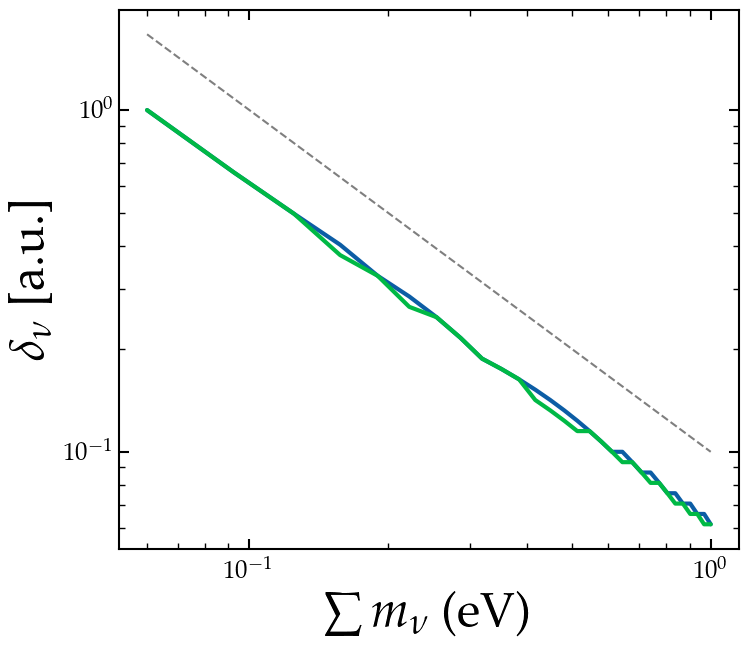

In [35]:
plt.loglog(mnl, dell_m/dell_m[0], label=r'$T_2=$1 s, seed: 42')
plt.loglog(mnl, dell_m2/dell_m2[0], label=r'$T_2=$5 s, seed: 23')

plt.loglog(mnl, 0.1*mnl**(-1), c='k', ls='--', alpha=0.5, lw=1.5)

plt.xlabel(r'$\sum m_{\nu}$ (eV)')
plt.ylabel(r'$\delta_{\nu}$ [a.u.]')
plt.show()

In [6]:
dell

[np.float64(2.96730240818886e+17),
 np.float64(2.96730240818886e+17),
 np.float64(2.96730240818886e+17),
 np.float64(3.2929712550971616e+17)]

### $N_{\rm shots}$ dependence

In [2]:
nsl = np.geomspace(5, 1000, 100)
dell, dell2, dell3, dell4 = [], [], [], []
see = 25
for ns in tqdm.tqdm(nsl):
    de, c2, _  = on.get_delta_jz(1, 0.16, T2=0.01, Nshots=int(ns), seed=see, d_init=1e16, d_fin=1e18, ndelta=200)
    dell.append(de)
    de, c2, _  = on.get_delta_jz(1, 0.16, T2=0.01, Nshots=int(ns), seed=see, d_init=1e16, d_fin=1e18, ndelta=200, squid_noise_ratio=0.01)
    dell2.append(de)
    de, c2, _  = on.get_delta_jz(1, 0.16, T2=0.01, Nshots=int(ns), seed=see, d_init=1e16, d_fin=1e18, ndelta=200, squid_noise_ratio=0.1)
    dell3.append(de)
    de, c2, _  = on.get_delta_jz(1, 0.16, T2=0.01, Nshots=int(ns), seed=see, d_init=1e16, d_fin=1e18, ndelta=200, squid_noise_ratio=1)
    dell4.append(de)

dell = np.array(dell)
dell2 = np.array(dell2)
dell3 = np.array(dell3)
dell4 = np.array(dell4)

100%|█████████████████████████████████████████| 100/100 [03:40<00:00,  2.21s/it]


In [102]:
dell0 = []
dell1 = []

for ns in tqdm.tqdm(nsl):
    de, c2, _  = on.get_delta_jz(1, 0.16, T2=0.01, Nshots=int(ns), seed=11, d_init=1e16, d_fin=1e18, ndelta=200)
    dell0.append(de)
    de, c2, _  = on.get_delta_jz(1, 0.16, T2=0.01, Nshots=int(ns), seed=76, d_init=1e16, d_fin=1e18, ndelta=200)
    dell1.append(de)

dell0 = np.array(dell0)
dell1 = np.array(dell1)

100%|█████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


In [25]:
# nsl = np.geomspace(1, 1000, 100)
# dell2 = []
# for ns in tqdm.tqdm(nsl):
#     de, c2, _  = on.get_delta_jz(10, 0.16, T2=0.1, Nshots=int(ns), seed=42, d_init=1e12, d_fin=1e15, ndelta=200, squid_noise_ratio=5.0)
#     dell2.append(de)

# dell2 = np.array(dell2)

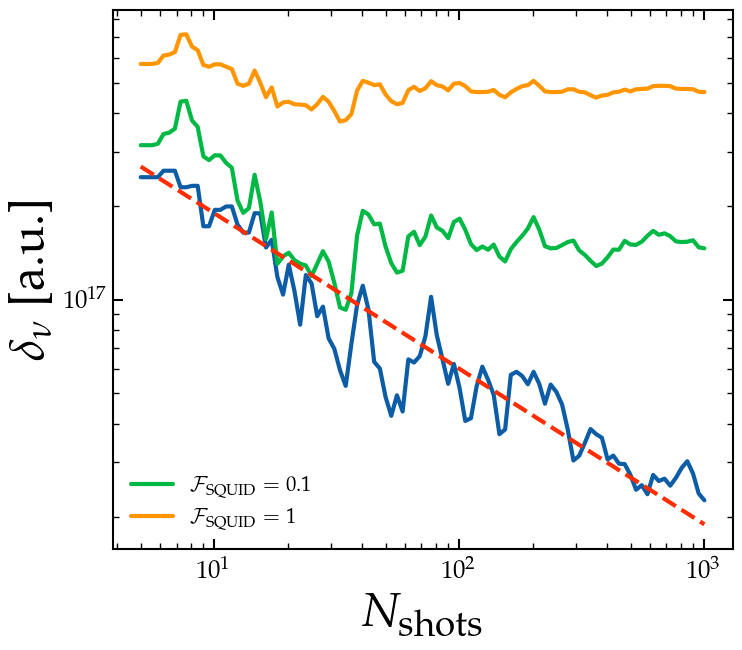

In [105]:
s = 0.5

meee = np.mean(np.array([dell, dell0, dell1]), axis=0)

plt.loglog(nsl, meee)
# plt.loglog(nsl, sn.gaussian_filter(dell, sigma=s), label=r'${\cal F}_{\rm SQUID}=0$')
# plt.loglog(nsl, sn.gaussian_filter(dell2, sigma=s), label=r'${\cal F}_{\rm SQUID}=0.01$')
plt.loglog(nsl, sn.gaussian_filter(dell3, sigma=s), label=r'${\cal F}_{\rm SQUID}=0.1$')
plt.loglog(nsl, sn.gaussian_filter(dell4, sigma=s), label=r'${\cal F}_{\rm SQUID}=1$')
plt.loglog(nsl, 6e17*nsl**(-0.5), ls='--')

plt.legend()
plt.xlabel(r'$N_{\rm shots}$')
plt.ylabel(r'$\delta_{\nu}$ [a.u.]')
plt.show()

In [33]:
de, c2, _  = on.get_delta_jz(10, 0.16, T2=0.1, Nshots=10, seed=42, d_init=1e12, d_fin=1e15, ndelta=200, squid_noise_ratio=1.0)
print("%.3e"%de)

1.956e+14


In [44]:
# fig, ax = plt.subplots(2, 2, figsize=(13, 8))
# fig.subplots_adjust(wspace=0.02, hspace=0.34)
# fs = 14

# #-----------------------------------------------------------------------------------------------------------
# ax[0,0].loglog(rl, me)
# ax[0,0].fill_between(rl, me-er, me+er, alpha=0.3)
# ax[0,0].loglog(rl, 0.028*rl**(-1.5), ls='--', label=r'$R^{-3/2}$', c='k', alpha=0.5, lw=1.5)

# ax[0,0].set_xlabel(r'$R$ (cm)', fontsize=25)
# ax[0,0].set_ylabel(r'$\delta_{\nu}$ [a.u.]')
# ax[0,0].legend(fontsize=fs, frameon=True)




# #-----------------------------------------------------------------------------------------------------------
# ax[0,1].loglog(sql, dell_sq/dell_sq[0])
# ax[0,1].loglog(sql, dell_sq2/dell_sq2[0])
# ax[0,1].loglog(sql, sql/sql, c='k', ls='--', label=r'${\cal F}_{\rm SQUID}=0$')
# ax[0,1].loglog(sql, 1.7*sql**(1/2), ls='--', lw=1, alpha=0.5,c='k', label=r'${\cal F}_{\rm SQUID}^{1/2}$')

# ax[0,1].set_ylim(0.6, 20)
# ax[0,1].legend(fontsize=fs, frameon=True)
# ax[0,1].set_xlabel(r'${\cal F}_{\rm SQUID}$', fontsize=25)
# ax[0,1].tick_params(labelleft=False, labelright=True)


# #-----------------------------------------------------------------------------------------------------------
# ax[1,0].loglog(t2l, dell_t2/dell_t2[0])
# ax[1,0].loglog(t2l, 0.1*t2l**(-1), ls='--', label=r'$T_2^{-1}$', c='crimson', lw=1.5)
# ax[1,0].loglog(t2l, 0.04*t2l**(-1.3), ls='--', label=r'$T_2^{-1.3}$', c='k', lw=1.5)
# ax[1,0].legend(fontsize=fs, frameon=True)
# ax[1,0].set_xlabel(r'$T_2$ (s)', fontsize=25)
# ax[1,0].set_ylabel(r'$\delta_\nu$ [a.u.]')

# #-----------------------------------------------------------------------------------------------------------
# s = 0.1
# ax[1,1].loglog(nsl, sn.gaussian_filter(dell, sigma=s)/dell[0], label=r'${\cal F}_{\rm SQUID}=0$')
# ax[1,1].loglog(nsl, sn.gaussian_filter(dell2, sigma=s)/dell2[0], label=r'${\cal F}_{\rm SQUID}=0.01$')
# ax[1,1].loglog(nsl, sn.gaussian_filter(dell3, sigma=s)/dell3[0], label=r'${\cal F}_{\rm SQUID}=0.1$')
# ax[1,1].loglog(nsl, sn.gaussian_filter(dell4, sigma=s)/dell4[0], label=r'${\cal F}_{\rm SQUID}=1$')
# ax[1,1].loglog(nsl, 2*nsl**(-0.5), ls='--', c='k', lw=1.5, alpha=0.4, label=r'$N_{\rm shots}^{-1/2}$')
# ax[1,1].set_xlabel(r'$N_{\rm shots}$', fontsize=25)
# ax[1,1].legend(fontsize=fs, frameon=True)
# ax[1,1].tick_params(labelleft=False, labelright=True)

# # plt.tight_layout()
# plt.show()
# #fig.savefig(main_dir+'plots/delta_scaling.pdf', bbox_inches='tight')

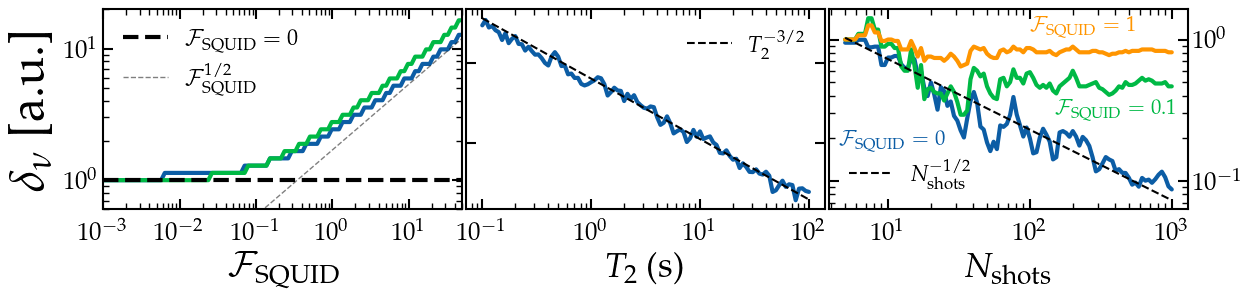

In [122]:
fig, ax = plt.subplots(1, 3, figsize=(14, 2.6))
fig.subplots_adjust(wspace=0.01, hspace=0.34)
fs = 16


#-----------------------------------------------------------------------------------------------------------
ax[0].loglog(sql, dell_sq/dell_sq[0])
ax[0].loglog(sql, dell_sq2/dell_sq2[0])
ax[0].loglog(sql, sql/sql, c='k', ls='--', label=r'${\cal F}_{\rm SQUID}=0$')
ax[0].loglog(sql, 1.7*sql**(1/2), ls='--', lw=1, alpha=0.5,c='k', label=r'${\cal F}_{\rm SQUID}^{1/2}$')

ax[0].set_xlim(1e-3, 50)
ax[0].set_ylim(0.6, 20)
ax[0].legend(fontsize=fs, frameon=False)
ax[0].set_xlabel(r'${\cal F}_{\rm SQUID}$', fontsize=25)
ax[0].set_ylabel(r'$\delta_\nu$ [a.u.]')
#ax[0].tick_params(labelleft=False, labelright=True)


#-----------------------------------------------------------------------------------------------------------
ax[1].loglog(t2l, mee/dell_t2[0])
ax[1].loglog(t2l, 0.04*t2l**(-1.5), ls='--', label=r'$T_2^{-3/2}$', c='k',lw=1.5)
ax[1].legend(fontsize=fs, frameon=False)
ax[1].set_xlabel(r'$T_2$ (s)', fontsize=25)
ax[1].tick_params(labelleft=False, labelright=False)
#ax[1].set_ylabel(r'$\delta_\nu$ [a.u.]')

#-----------------------------------------------------------------------------------------------------------
s = 0.1
#ax[2].loglog(nsl, sn.gaussian_filter(dell, sigma=s)/dell[0])#, label=r'${\cal F}_{\rm SQUID}=0$')
ax[2].loglog(nsl, meee/dell[0])
#ax[2].loglog(nsl, sn.gaussian_filter(dell2, sigma=s)/dell2[0], label=r'${\cal F}_{\rm SQUID}=0.01$')
ax[2].loglog(nsl, sn.gaussian_filter(dell3, sigma=s)/dell3[0])#, label=r'${\cal F}_{\rm SQUID}=0.1$')
ax[2].loglog(nsl, sn.gaussian_filter(dell4, sigma=s)/dell4[0])#, label=r'${\cal F}_{\rm SQUID}=1$')
ax[2].loglog(nsl, 2.3*nsl**(-0.5), ls='--', c='k', lw=1.5, alpha=1, label=r'$N_{\rm shots}^{-1/2}$')
ax[2].text(100, 1.15,r'${\cal F}_{\rm SQUID}=1$',c='C2', fontsize=15)
ax[2].text(150, 0.3,r'${\cal F}_{\rm SQUID}=0.1$',c='C1', fontsize=15)
ax[2].text(4.5, 0.18,r'${\cal F}_{\rm SQUID}=0$',c='C0', fontsize=15)
ax[2].set_xlabel(r'$N_{\rm shots}$', fontsize=25)
ax[2].legend(fontsize=fs)
ax[2].tick_params(labelleft=False, labelright=True)

# plt.tight_layout()
plt.show()
fig.savefig(main_dir+'plots/delta_scaling.pdf', bbox_inches='tight')

### $T_2$ dependence

In [48]:
t2l = np.geomspace(0.1, 100, 100)
dell_t2 = []
for tt in tqdm.tqdm(t2l):
    de, c2,_  = on.get_delta_jz(10, 0.16, T2=tt, Nshots=100, seed=42, d_init=1e8, d_fin=1e14, ndelta=200)
    dell_t2.append(de)

dell_t2 = np.array(dell_t2)

100%|█████████████████████████████████████████| 100/100 [08:48<00:00,  5.29s/it]


In [51]:
dell_t3 = []
dell_t4 = []
for tt in tqdm.tqdm(t2l):
    de, c2,_  = on.get_delta_jz(10, 0.16, T2=tt, Nshots=100, seed=24, d_init=1e8, d_fin=1e14, ndelta=200)
    dell_t3.append(de)
    de, c2,_  = on.get_delta_jz(10, 0.16, T2=tt, Nshots=100, seed=11, d_init=1e8, d_fin=1e14, ndelta=200)
    dell_t4.append(de)

dell_t3 = np.array(dell_t3)
dell_t4 = np.array(dell_t4)

100%|█████████████████████████████████████████| 100/100 [18:10<00:00, 10.91s/it]


In [57]:
mee = np.mean(np.array([dell_t2,dell_t3,dell_t4,],),  axis=0)

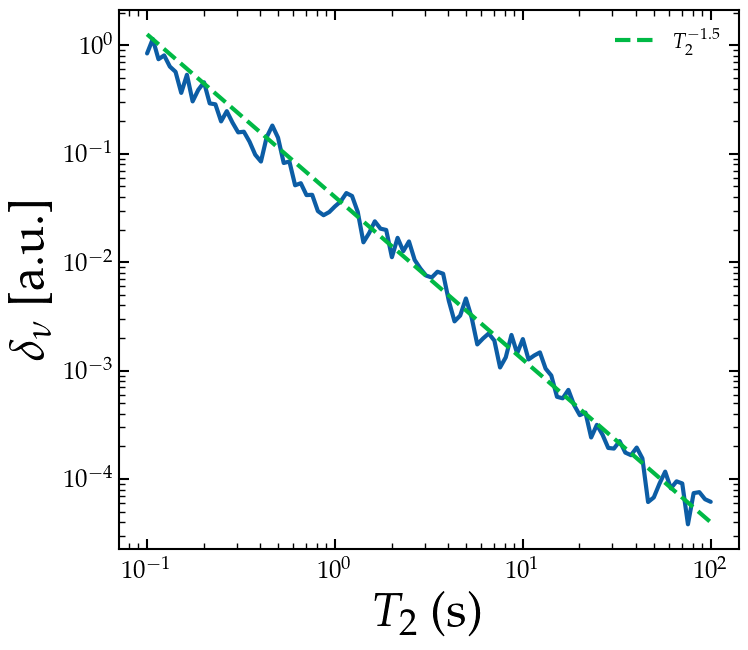

In [61]:
# plt.loglog(t2l, dell_t2/dell_t2[0])
# plt.loglog(t2l, dell_t3/dell_t3[0])
# plt.loglog(t2l, dell_t4/dell_t4[0])
plt.loglog(t2l, mee/dell_t2[0])
# plt.loglog(t2l, 0.1*t2l**(-1), ls='--', label=r'$T_2^{-1}$')
plt.loglog(t2l, 0.04*t2l**(-1.5), ls='--', label=r'$T_2^{-1.5}$')

plt.xlabel(r'$T_2$ (s)')
plt.ylabel(r'$\delta_{\nu}$ [a.u.]')
plt.legend()
plt.show()

In [84]:
dell_r

[np.float64(1431458937523481.5)]

### $R$ dependence

In [28]:
rl = np.geomspace(0.1, 10, 30)
dell_r = []
dell_r2 = []
for r in tqdm.tqdm(rl):
    de, c2, _  = on.get_delta_jz(r, 0.16, T2=1, Nshots=10, seed=51, d_init=1e12, d_fin=1e17, ndelta=200)
    de2, c2, _  = on.get_delta_jz(r, 0.16, T2=1, Nshots=10, seed=12, d_init=1e12, d_fin=1e17, ndelta=200)
    dell_r.append(de)
    dell_r2.append(de2)

dell_r = np.array(dell_r)
dell_r2 = np.array(dell_r2)

100%|███████████████████████████████████████████| 30/30 [00:58<00:00,  1.93s/it]


In [92]:
dell_r03 = dell_r
dell_r04 = dell_r2

In [110]:
np.mean(np.array([dell_r01/dell_r01[0], dell_r02/dell_r02[0], dell_r03/dell_r03[0], dell_r04/dell_r04[0]]), axis=0)

array([1.        , 0.79340967, 0.6294989 , 0.49945051, 0.38173878,
       0.30287524, 0.24030414, 0.1878783 , 0.14906446, 0.11826918,
       0.09383591, 0.07360363, 0.05690076, 0.04514561, 0.03581896,
       0.02800691, 0.02222096, 0.01763032, 0.01382807, 0.01097133,
       0.00870476, 0.00680939, 0.00540264, 0.00428651, 0.00335249,
       0.00269306, 0.0021367 , 0.00171715, 0.00139639, 0.00112444])

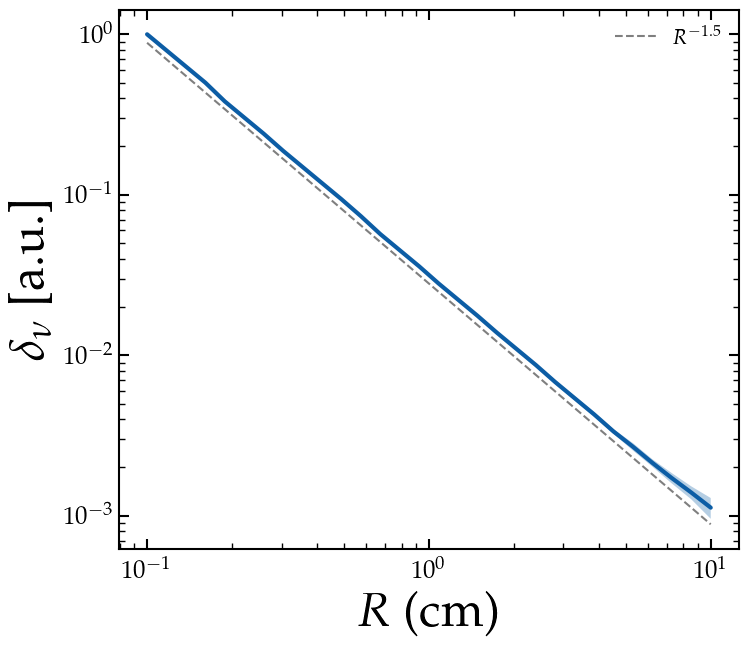

In [129]:
#plt.loglog(rl, dell_r01/dell_r01[0], label='seed: 42')
#plt.loglog(rl, dell_r02/dell_r02[0], label='seed: 23')
#plt.loglog(rl, dell_r03/dell_r03[0], label='seed: 42')
#plt.loglog(rl, dell_r04/dell_r04[0], label='seed: 23')
me = np.mean(np.array([dell_r01/dell_r01[0], dell_r02/dell_r02[0], dell_r03/dell_r03[0], dell_r04/dell_r04[0]]), axis=0)
er = np.std(np.array([dell_r01/dell_r01[0], dell_r02/dell_r02[0], dell_r03/dell_r03[0], dell_r04/dell_r04[0]]), axis=0)
plt.loglog(rl, me)
plt.fill_between(rl, me-er, me+er, alpha=0.3)

#plt.loglog(rl, 0.003*rl**(-3), ls='--', label=r'$R^{-3}$')
plt.loglog(rl, 0.028*rl**(-1.5), ls='--', label=r'$R^{-1.5}$', c='k', alpha=0.5, lw=1.5)

plt.xlabel(r'$R$ (cm)')
plt.ylabel(r'$\delta_{\nu}$ [a.u.]')
plt.legend()
plt.show()

### $p$ dependence

In [45]:
pl = np.geomspace(0.001, 1, 20)
dell_p = []
dell_p2 = []
for p in tqdm.tqdm(pl):
    de, c2, _  = on.get_delta_jz(10, 0.16,  p_init=p, T2=1, Nshots=100, seed=42, d_init=1e11, d_fin=1e22, ndelta=200)
    de2, c2, _  = on.get_delta_jz(10, 0.16, p_init=p, T2=1, Nshots=100, seed=23, d_init=1e11, d_fin=1e22, ndelta=200)
    dell_p.append(de)
    dell_p2.append(de2)

dell_p = np.array(dell_p)
dell_p2 = np.array(dell_p2)

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]


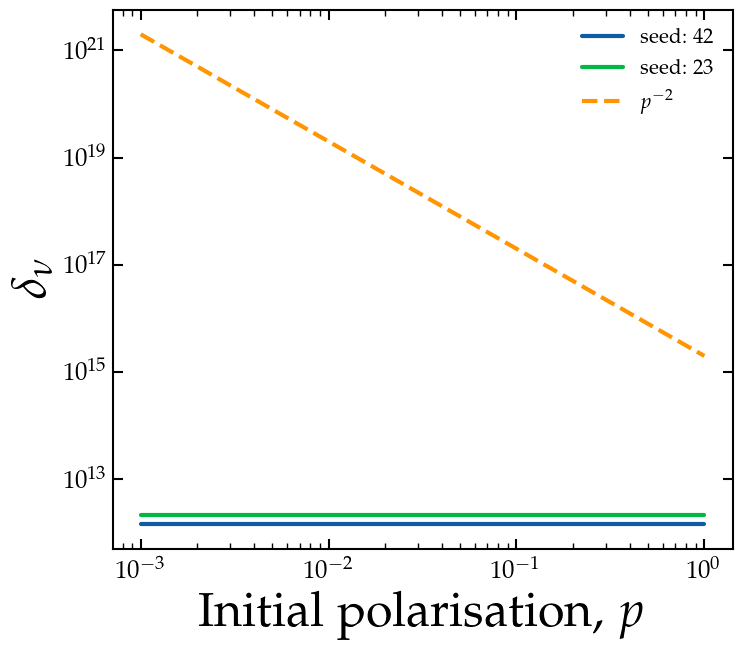

In [46]:
plt.loglog(pl, dell_p, label='seed: 42')
plt.loglog(pl, dell_p2, label='seed: 23')

plt.loglog(pl, 2e15*pl**(-2), ls='--', label=r'$p^{-2}$')

plt.xlabel(r'Initial polarisation, $p$')
plt.ylabel(r'$\delta_{\nu}$')
plt.legend()
plt.show()

### SQUID noise dependence

In [6]:
sql = np.geomspace(0.001, 50, 100)
dell_sq = []
dell_sq2 = []
for sq in tqdm.tqdm(sql):
    de, c2, _  = on.get_delta_jz(10, 0.16,  T2=0.1, Nshots=10, seed=42, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=sq)
    de2, c2, _  = on.get_delta_jz(10, 0.16, T2=0.1, Nshots=10, seed=23, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=sq)
    dell_sq.append(de)
    dell_sq2.append(de2)

dell_sq = np.array(dell_sq)
dell_sq2 = np.array(dell_sq2)

100%|█████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


In [151]:
de0, c2, _  = on.get_delta_jz(10, 0.16,  T2=0.1, Nshots=10, seed=42, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=0)
print("%.3e"%de0)

3.449e+14


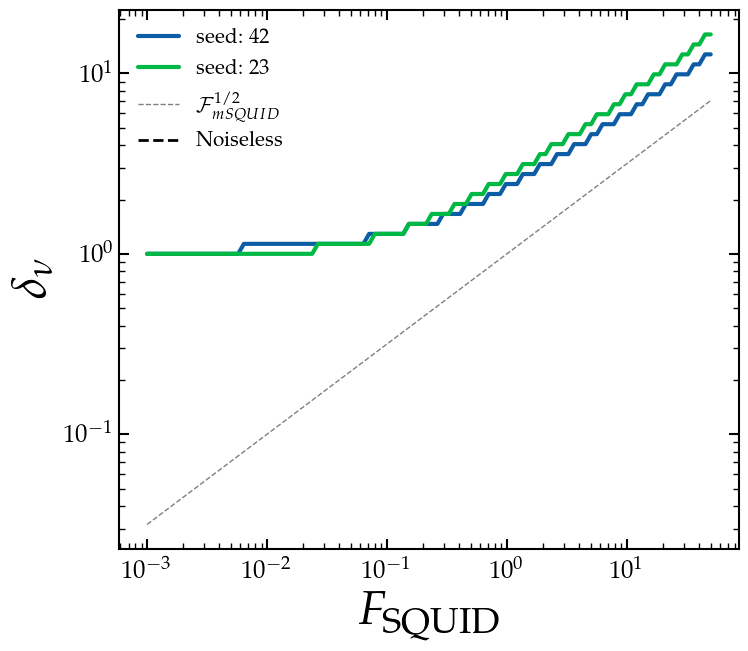

In [9]:
plt.loglog(sql, dell_sq/dell_sq[0], label='seed: 42')
plt.loglog(sql, dell_sq2/dell_sq2[0], label='seed: 23')
plt.loglog(sql, sql**(1/2), ls='--', lw=1, alpha=0.5,c='k', label='${\cal F}_{\rm SQUID}^{1/2}$')

de0, c2, _ = on.get_delta_jz(10, 0.16,  T2=1, Nshots=100, seed=42, d_init=1e11, d_fin=1e22, ndelta=200, squid_noise_ratio=0)

plt.hlines(de0, xmin=1e-3, xmax=50, ls='--', color='k', label='Noiseless', lw=2)
# plt.ylim(1e15,1e17)
plt.xlabel(r'$F_{\rm SQUID}$')
plt.ylabel(r'$\delta_{\nu}$')
plt.legend()
plt.show()

### $n_s$ dependence

In [5]:
nsl = np.geomspace(1e21,1e23,50)
dell_ns = []
dell_ns2 = []
for nns in tqdm.tqdm(nsl):
    de, c2  = on.get_delta_jz(10, 0.16,  T2=1, Nshots=100, seed=42, d_init=1e11, d_fin=1e22, ndelta=200, ns=nns)
    de2, c2  = on.get_delta_jz(10, 0.16, T2=1, Nshots=100, seed=23, d_init=1e11, d_fin=1e22, ndelta=200, ns=nns)
    dell_ns.append(de)
    dell_ns2.append(de2)

dell_ns = np.array(dell_ns)
dell_ns2 = np.array(dell_ns2)

100%|████████████████████████████████████████████████████████████| 50/50 [01:27<00:00,  1.76s/it]


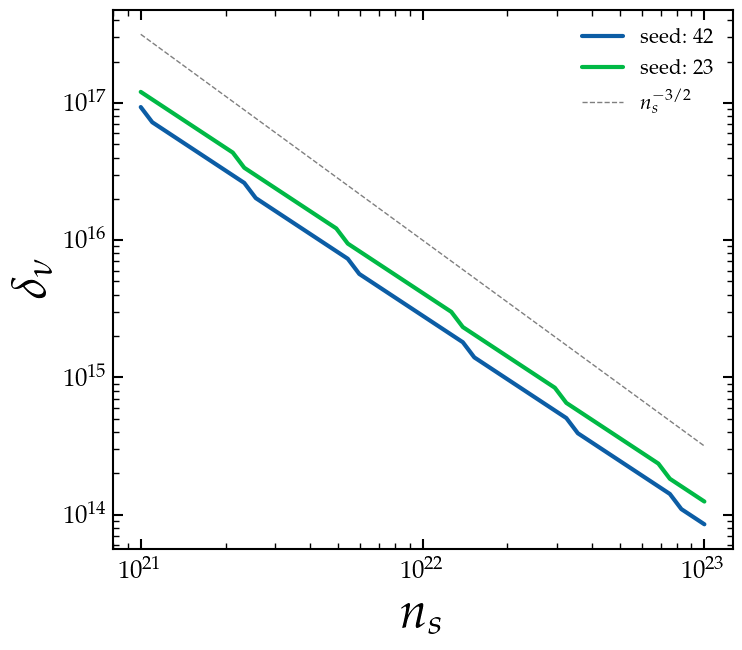

In [21]:
plt.loglog(nsl, dell_ns, label='seed: 42')
plt.loglog(nsl, dell_ns2, label='seed: 23')
plt.loglog(nsl, 1e49*nsl**(-3/2), ls='--', lw=1, alpha=0.5,c='k', label='$n_s^{-3/2}$')


plt.xlabel(r'$n_s$')
plt.ylabel(r'$\delta_{\nu}$')
plt.legend()
plt.show()

### $f_s$ dependence

In [25]:
dell_fs = []
fsl = np.geomspace(1e5, 1e7, 50)

for fs in tqdm.tqdm(fsl):
    de, c2, c2l = on.get_delta_jz(10, 0.16, p_init=1, T2=0.01, Nshots=10, seed=42, d_init=1e8, d_fin=1e16, ndelta=100,
                     chi2_crit=2.7, squid_noise_ratio=0.0, sampf=fs)
    dell_fs.append(de)
    #print("delta: %.3e"%de)

dell_fs = np.array(dell_fs)

100%|█████████████████████████████████████████████████████████████████████████| 50/50 [00:50<00:00,  1.01s/it]


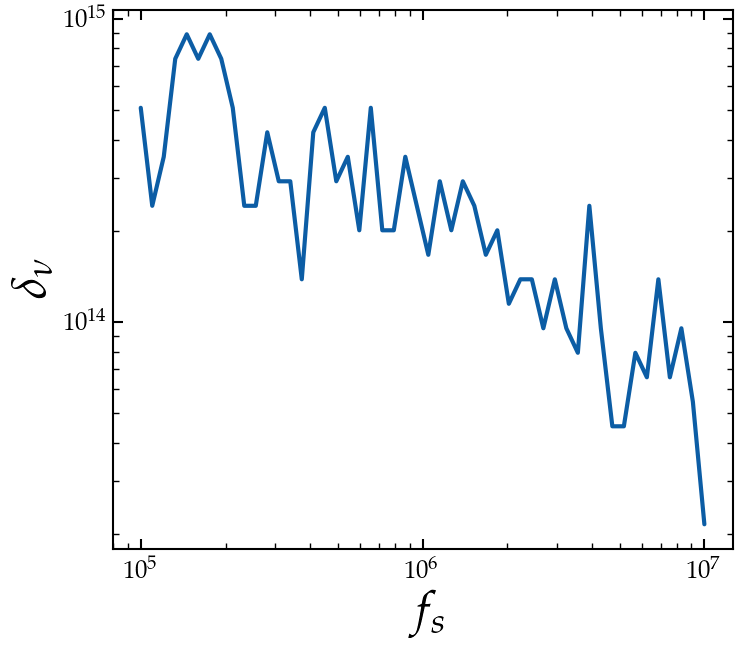

In [26]:
plt.loglog(fsl, dell_fs, label='')
#plt.loglog(nsl, 1e49*nsl**(-3/2), ls='--', lw=1, alpha=0.5,c='k', label='$n_s^{-3/2}$')


plt.xlabel(r'$f_s$')
plt.ylabel(r'$\delta_{\nu}$')
#plt.legend()
plt.show()

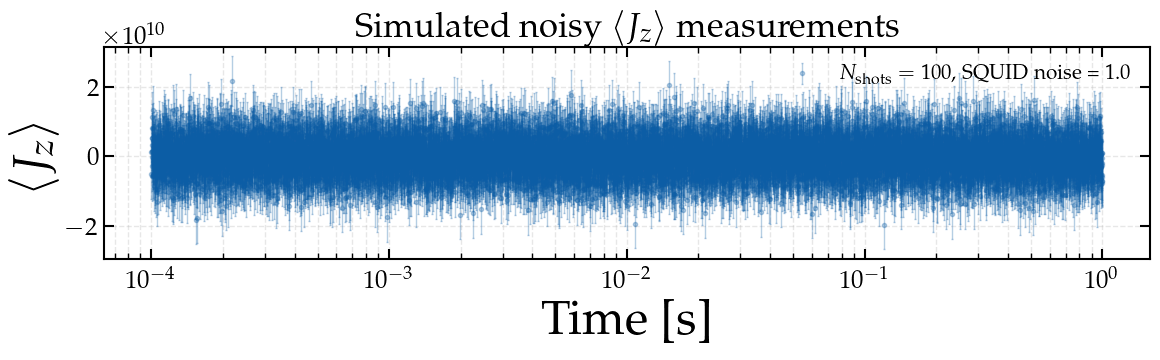

In [78]:
N = int(1e22)
Nshots = 100
sampf = 1e4
tf = 1
ti = 1 / sampf
squid_noise_ratio = 1.0  # Adjust as needed
sk = 1  # skip factor for plotting

# Time grid
n_times = int((tf - ti) * sampf)
t_exp = np.geomspace(ti, tf, n_times)

# Simulate noisy measurements of J_z (mean zero)
np.random.seed(42)
jz_true_mean = 0.0
jz_true_std = np.sqrt(N / 4)
Jz_samples = np.random.normal(jz_true_mean, jz_true_std, size=(n_times, Nshots))
Jz_mean_exp = np.mean(Jz_samples, axis=1)

# Total error: quantum + SQUID noise
sigma_jz = np.sqrt(N / 4 / Nshots * (1 + squid_noise_ratio)) * np.ones(n_times)

# Plot
plt.figure(figsize=(12, 4))
plt.errorbar(t_exp[::sk], Jz_mean_exp[::sk], yerr=sigma_jz[::sk],
             fmt='o', label=fr'$N_{{\rm shots}}={Nshots}$, SQUID noise = {squid_noise_ratio}',
             alpha=0.3, markersize=3, lw=1, capsize=1)

plt.xscale('log')
plt.xlabel("Time [s]")
plt.ylabel(r"$\langle J_z \rangle$")
plt.title("Simulated noisy $\langle J_z \\rangle$ measurements")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

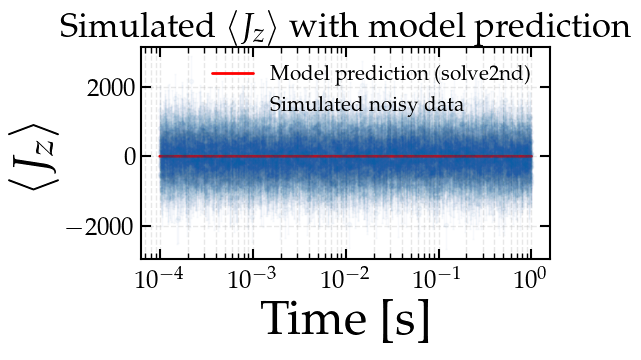

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Example parameters (adjust to your actual values)
N = int(1e8)
Nshots = 100
sampf = 1e4
tf = 1
ti = 1 / sampf
squid_noise_ratio = 1.0
sk = 1  # skip factor for plotting


delta = 1e15

# Constants and problem parameters (update as needed)
R = 10.0          # example radius in cm
mnu = 0.15        # example neutrino mass in eV
B = 0.1           # magnetic field in Tesla
T2 = 1.0          # coherence time in seconds
p_init = 1.0
tf_ratio = 0.2
seed = 42

# Time grid
n_times = int((tf - ti) * sampf)
t_exp = np.geomspace(ti, tf, n_times)

# Simulate noisy Jz measurements
np.random.seed(seed)
jz_true_mean = 0.0
jz_true_std = np.sqrt(N / 4)
Jz_samples = np.random.normal(jz_true_mean, jz_true_std, size=(n_times, Nshots))
Jz_mean_exp = np.mean(Jz_samples, axis=1)
sigma_jz = np.sqrt(N / 4 / Nshots * (1 + squid_noise_ratio)) * np.ones(n_times)

# Compute model prediction for Jz from solve2nd
# Assuming ga.compute_ratio and solve2nd are imported and available
gratio, gm = ga.compute_ratio(mnu, 2 * np.pi * 11.78e6 * B / (1 / 6.58e-16))

fsup = 4 * (1 / 0.037 * R)**2
Ncode = int(1e8)

tmin_code = min(t_exp) * N * gm * delta / fsup  # Using delta=1 for illustration
tmax_code = max(t_exp) * N * gm * delta / fsup * tf_ratio

t_model, jz_model, _, _, _ = on.solve2nd(
    Ncode,
    gp_ratio=gratio,
    gd_ratio=Ncode * tf_ratio,
    p_init=p_init,
    ti=tmin_code,
    tf=tmax_code,
    ntimes=n_times
)

# Plot
plt.figure(figsize=(6, 4))

# Noisy data with error bars
plt.errorbar(t_exp[::sk], Jz_mean_exp[::sk], yerr=sigma_jz[::sk],
             fmt='o', alpha=0.03, markersize=3, lw=1, capsize=1,
             label='Simulated noisy data')

# Model prediction curve
plt.plot(t_exp, -jz_model/N, 'r-', lw=2, label='Model prediction (solve2nd)')

plt.xscale('log')
plt.xlabel("Time [s]")
plt.ylabel(r"$\langle J_z \rangle$")
plt.title("Simulated $\langle J_z \\rangle$ with model prediction")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

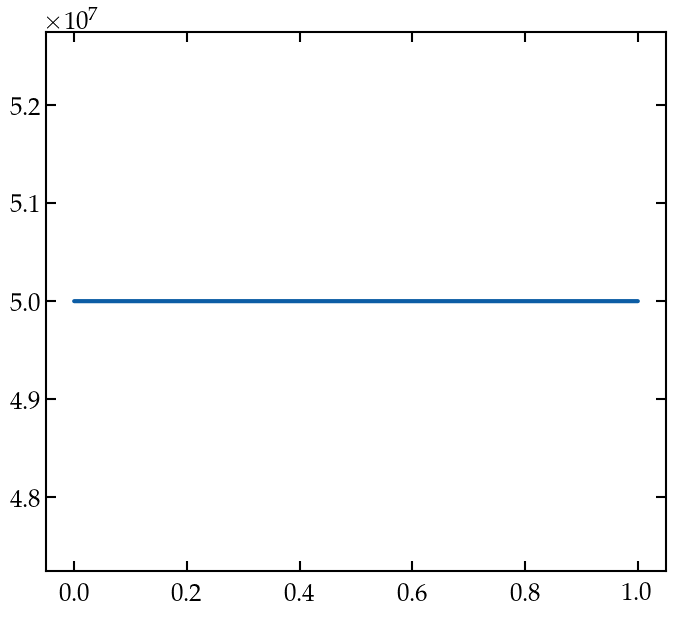

In [24]:
plt.plot(t_exp, -jz_model)

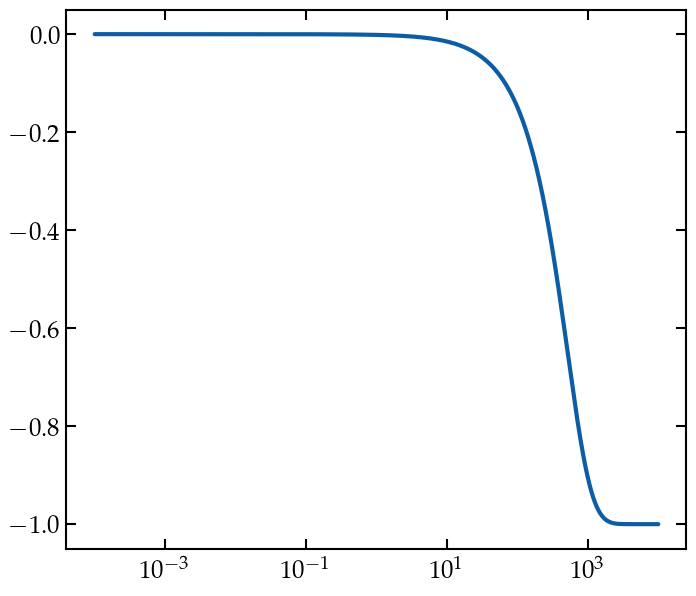

In [96]:
# plt.semilogx(t, np.abs(jz)/N*2-1)
#plt.plot(t_exp[::sk], Jz_mean_exp[::sk])


In [52]:
Jz_mean_exp

array([-519.23258697,  111.52293525,  324.4812655 , ...,   87.13924401,
       -262.62892485, -604.10106972])

In [53]:
Ncode

100000000